In [1]:
from random import choice
from tqdm.notebook import tqdm
from json import loads
from pprint import pprint
from textwrap import dedent
import re

from collections import Counter
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
import os 
import logging
import sys

# Setup OPENAI_API_KEY

os.environ["OPENAI_API_KEY"] = "" 

# Setup logging

log = logging.getLogger(__name__)
logging.basicConfig(format="%(asctime)s | %(levelname)s | %(message)s", level=logging.INFO)

# Update sys.path (or use PYTHONPATH)

sys.path.insert(0, '..')

#### Get Data

In [3]:
import pandas as pd

df = pd.read_csv("./data/input/rest_quad_test_input.csv")
df=df.dropna(subset=["text"])
df.head()

,text,term_true,cat_true,pol_true
0,yum !,['FOOD'],['QUALITY'],['2']
1,serves really good sushi .,['FOOD'],['QUALITY'],['2']
2,not the biggest portions but adequate .,"['FOOD', 'FOOD']","['STYLE_OPTIONS', 'STYLE_OPTIONS']","['1', '1']"
3,green tea creme brulee is a must !,['FOOD'],['QUALITY'],['2']
4,it has great sushi and even better service .,"['FOOD', 'SERVICE']","['QUALITY', 'GENERAL']","['2', '2']"


In [4]:
df.shape

(583, 4)

In [5]:
def fixJSON(jsonStr):
    try:
        jsonStr = re.sub(r'\\', '', jsonStr)

        jsonStr = re.sub(r'{"', '{\"', jsonStr)
        jsonStr = re.sub(r'{ "', '{"', jsonStr)
        jsonStr = re.sub(r'"}', '\"}', jsonStr)
        jsonStr = re.sub(r'" }', '\"}', jsonStr)

        jsonStr = re.sub(r'":"', '\":\"', jsonStr)
        jsonStr = re.sub(r'" : "', '\":\"', jsonStr)
        jsonStr = re.sub(r'":', '\":', jsonStr)
        jsonStr = re.sub(r'" :', '\":', jsonStr)
        jsonStr = re.sub(r':"', ':\"', jsonStr)
        jsonStr = re.sub(r': "', ':\"', jsonStr)

        jsonStr = re.sub(r'","', '\",\"', jsonStr)
        jsonStr = re.sub(r'" , "', '\",\"', jsonStr)
        jsonStr = re.sub(r'",', '\",', jsonStr)
        jsonStr = re.sub(r'" ,', '\",', jsonStr)
        jsonStr = re.sub(r',"', ',\"', jsonStr)
        jsonStr = re.sub(r', "', ',\"', jsonStr)

        jsonStr = re.sub(r'\["', '\[\"', jsonStr)
        jsonStr = re.sub(r'"\]', '\"\]', jsonStr)

        split_1 = jsonStr.split('[')
        split_1 = '['+split_1[1]
#         print(split_1)
        split_2 = split_1.split(']')
        split_2 = split_2[0]+']'

        jsonStr = split_2
        
        print(loads(jsonStr))
        
        return loads(jsonStr)
    except:
        return []

#### Configure GPT-3

In [6]:
import openai
from textwrap import dedent

openai.api_key = os.getenv("OPENAI_API_KEY")

ABSA_PROMPT = dedent(
    f"""
    Please extract aspect categories, aspect terms, related segments and related sentiments from the following text and format output in JSON:

    judging from previous posts this used to be a good place , but not any longer .
    
    [
      {{ "category": "General", aspect": "Restaurant", "segment": "this used to be a good place , but not any longer", "sentiment": "negative" }}
    ]
    
    great wine selection , gigondas is worth the price , and the house champagne is a great value .
    
    [
      {{ "category": "Style_Options", "aspect": "Drinks", "segment": "great wine selection", "sentiment": "positive" }},
      {{ "category": "Quality", "aspect": "Drinks", "segment": "gigondas is worth the price", "sentiment": "positive" }},
      {{ "category": "Prices", "aspect": "Drinks", "segment": "house champagne is a great value", "sentiment": "positive" }}
    ]    
    
    ambience is so cute and quaint , good for business although we were there on vacation .
    
    [
      {{ "category": "General", "aspect": "Ambience", "segment": "ambience is so cute", "sentiment": "positive" }},
      {{ "category": "General", "aspect": "Ambience", "segment": "ambience is quaint", "sentiment": "positive" }},
      {{ "category": "Miscellaneous", "aspect": "Restaurant", "segment": "good for business although we were there on vacation", "sentiment": "positive" }}    
    ]       
    
    noodles with shrimp and chicken and coconut juice is the must !
    
    [
      {{ "category": "Quality", "aspect": "Food", "segment": "noodles with shrimp and chicken and coconut juice is the must !", "sentiment": "positive" }}
    ]
    
    indoor was very cozy and cute .
    
    [
      {{ "category": "General", "aspect": "Ambience", "segment": "indoor was very cozy", "sentiment": "positive" }},
      {{ "category": "General", "aspect": "Ambience", "segment": "cute", "sentiment": "positive" }}
    ]    

    its a little out of the way if you do n ' t live in the neighborhood , but definitely worth the trip from wherever you are .
    
    [
      {{ "category": "General", "aspect": "Location", "segment": "its a little out of the way", "sentiment": "neutral" }},
      {{ "category": "General", "aspect": "Restaurant", "segment": "definitely worth the trip", "sentiment": "positive" }}
    ]

    mine tasted like the bartender had forgotten to add the tequila .
    
    [
      {{ "category": "Quality", "aspect": "Drinks", "segment": "tasted like the bartender had forgotten to add the tequila", "sentiment": "negative" }}
    ]
    
    everyone was cheerfully cooperative and helpful .
    
    [
      {{ "category": "General", "aspect": "Service", "segment": "cheerfully cooperative", "sentiment": "positive" }},
      {{ "category": "General", "aspect": "Service", "segment": "helpful", "sentiment": "positive" }}
    ]
    
    the wine list was extensive - though the staff did not seem knowledgeable about wine pairings .
    
    [
      {{ "category": "Style_Options", "aspect": "Drinks", "segment": "the wine list was extensive", "sentiment": "positive" }},
      {{ "category": "General", "aspect": "Service", "segment": "the staff did not seem knowledgeable", "sentiment": "negative" }}
    ]

    the four seasons has history and it is a sort of landmark of new york city restaurants , but trust me , they will charge you through the nose just so that you can say ` ` i ' ve been to the four seasons restaurant ' ' . 
    
    [
      {{ "category": "Miscellaneous", "aspect": "Restaurant", "segment": "the four seasons has history and it is a sort of landmark of new york city restaurants", "sentiment": "neutral" }},
      {{ "category": "Prices", "aspect": "Restaurant", "segment": "they will charge you through the nose": "negative" }}
    ]
"""
)



def analyze(
    text,
    prompt_text=ABSA_PROMPT,
    extra_prompt="",
    temperature=0.5,
#     max_tokens=128,
    max_tokens=1024,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
):
    prompt = f"{prompt_text}\n{extra_prompt}\n{text}"

    return openai.Completion.create(
        model="text-davinci-002",
        prompt=prompt,
        temperature=temperature,
        max_tokens=max_tokens,
        top_p=top_p,
        frequency_penalty=frequency_penalty,
        presence_penalty=presence_penalty,
    )

#### Run GPT-3

In [7]:
analysis_results = []
extra_prompts = []

logging.getLogger("openai").setLevel(logging.INFO)
logging.getLogger("requests").setLevel(logging.WARNING)

for i in tqdm(range(len(df)), desc="Analyzing reviews"):
    text = df.loc[i, "text"]

    log.info(f"Analyzing feedback - \nText: {text}\n")

    extra_prompt = choice(extra_prompts) if extra_prompts else ""

    res = analyze(
        text=text,
        extra_prompt="",
        max_tokens=2048,
        temperature=0.1,
        top_p=1,
    )

    raw_json = res["choices"][0]["text"].strip()
#     print(res["choices"][0]["text"])
#     print(raw_json)
    try:
        json_data = loads(raw_json)
        analysis_results.append(json_data)
        log.debug(f"JSON response: {pprint(json_data)}")
        extra_prompts.append(f"\n{text}\n{raw_json}")
    except Exception as e:
        log.error(f"Failed to parse '{raw_json}' -> {e}")
        analysis_results.append(fixJSON(raw_json))
        
df["analysis"] = analysis_results
df.to_csv("./data/output/restaurant/rest_out_exp1.csv", index=False)


Analyzing reviews:   0%|          | 0/583 [00:00<?, ?it/s]

2023-03-29 10:38:59,671 | INFO | Analyzing feedback - 
Text: yum !

2023-03-29 10:39:01,359 | INFO | Analyzing feedback - 
Text: serves really good sushi .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'yum !',
  'sentiment': 'positive'}]


2023-03-29 10:39:02,725 | INFO | Analyzing feedback - 
Text: not the biggest portions but adequate .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'serves really good sushi',
  'sentiment': 'positive'}]


2023-03-29 10:39:04,631 | INFO | Analyzing feedback - 
Text: green tea creme brulee is a must !



[{'aspect': 'Food',
  'category': 'Quantity',
  'segment': 'not the biggest portions',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quantity',
  'segment': 'but adequate',
  'sentiment': 'positive'}]


2023-03-29 10:39:06,097 | INFO | Analyzing feedback - 
Text: it has great sushi and even better service .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'green tea creme brulee is a must !',
  'sentiment': 'positive'}]


2023-03-29 10:39:07,917 | INFO | Analyzing feedback - 
Text: the entire staff was extremely accomodating and tended to my every need .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'it has great sushi',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'even better service',
  'sentiment': 'positive'}]


2023-03-29 10:39:10,726 | INFO | Analyzing feedback - 
Text: i ' ve been to this restaurant over a dozen times with no complaints to date .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the entire staff was extremely accomodating',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'tended to my every need',
  'sentiment': 'positive'}]


2023-03-29 10:39:12,222 | INFO | Analyzing feedback - 
Text: the owner is belligerent to guests that have a complaint .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i ' ve been to this restaurant over a dozen times with no "
             'complaints to date',
  'sentiment': 'positive'}]


2023-03-29 10:39:13,533 | INFO | Analyzing feedback - 
Text: good food !



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the owner is belligerent to guests that have a complaint',
  'sentiment': 'negative'}]


2023-03-29 10:39:14,732 | INFO | Analyzing feedback - 
Text: this is a great place to get a delicious meal .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'good food !',
  'sentiment': 'positive'}]


2023-03-29 10:39:16,003 | INFO | Analyzing feedback - 
Text: the staff is pretty friendly .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'this is a great place to get a delicious meal',
  'sentiment': 'positive'}]


2023-03-29 10:39:17,149 | INFO | Analyzing feedback - 
Text: the onion rings are great !



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the staff is pretty friendly',
  'sentiment': 'positive'}]


2023-03-29 10:39:18,344 | INFO | Analyzing feedback - 
Text: the lemon chicken tasted like sticky sweet donuts and the honey walnut prawns , the few they actually give you . . . . . were not good .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the onion rings are great',
  'sentiment': 'positive'}]


2023-03-29 10:39:20,492 | INFO | Analyzing feedback - 
Text: nice ambience , but highly overrated place .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the lemon chicken tasted like sticky sweet donuts',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quantity',
  'segment': 'the honey walnut prawns , the few they actually give you . . . . '
             '.',
  'sentiment': 'negative'}]


2023-03-29 10:39:22,285 | INFO | Analyzing feedback - 
Text: worst service i ever had



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'nice ambience',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'highly overrated place',
  'sentiment': 'negative'}]


2023-03-29 10:39:23,390 | ERROR | Failed to parse '.

[
  { "category": "General", "aspect": "Service", "segment": "worst service i ever had", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:39:23,393 | INFO | Analyzing feedback - 
Text: everyone that sat in the back outside agreed that it was the worst service we had ever received .



[{'category': 'General', 'aspect': 'Service', 'segment': 'worst service i ever had', 'sentiment': 'negative'}]


2023-03-29 10:39:24,785 | INFO | Analyzing feedback - 
Text: our waiter was non - existent and after our food finally arrived over an hour after we ordered , we were not given any water or utensils .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the worst service we had ever received',
  'sentiment': 'negative'}]


2023-03-29 10:39:26,886 | INFO | Analyzing feedback - 
Text: i complained to the manager , but he was not even apologetic .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'our waiter was non - existent',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'after our food finally arrived over an hour after we ordered , '
             'we were not given any water or utensils',
  'sentiment': 'negative'}]


2023-03-29 10:39:28,710 | INFO | Analyzing feedback - 
Text: fabulous italian food !



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'i complained to the manager',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'he was not even apologetic',
  'sentiment': 'negative'}]


2023-03-29 10:39:29,759 | INFO | Analyzing feedback - 
Text: – i highly recommend mioposto .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'fabulous italian food',
  'sentiment': 'positive'}]


2023-03-29 10:39:30,982 | INFO | Analyzing feedback - 
Text: i am so happy to have a wonderful italian restaurant in my neighborhood .



[{'aspect': 'Restaurant',
  'category': 'Recommendation',
  'segment': 'i highly recommend mioposto',
  'sentiment': 'positive'}]


2023-03-29 10:39:32,319 | INFO | Analyzing feedback - 
Text: the wine list is wonderful and the food reminds me of my recent trip to italy .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i am so happy to have a wonderful italian restaurant in my '
             'neighborhood',
  'sentiment': 'positive'}]


2023-03-29 10:39:34,224 | INFO | Analyzing feedback - 
Text: i love this restaurant



[{'aspect': 'Drinks',
  'category': 'Style_Options',
  'segment': 'the wine list is wonderful',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food reminds me of my recent trip to italy',
  'sentiment': 'positive'}]


2023-03-29 10:39:35,363 | ERROR | Failed to parse '!

[
  { "category": "General", "aspect": "Restaurant", "segment": "i love this restaurant", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:39:35,365 | INFO | Analyzing feedback - 
Text: – i will never forget the amazing meal , service , and ambiance i experience at this restaurant .



[{'category': 'General', 'aspect': 'Restaurant', 'segment': 'i love this restaurant', 'sentiment': 'positive'}]


2023-03-29 10:39:37,628 | INFO | Analyzing feedback - 
Text: the wine list is incredible and extensive and diverse , the food is all incredible and the staff was all very nice , good at their jobs and cultured .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'amazing meal',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'amazing service',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'amazing ambiance',
  'sentiment': 'positive'}]


2023-03-29 10:39:40,077 | INFO | Analyzing feedback - 
Text: i have not a bad thing to say about this place .



[{'aspect': 'Drinks',
  'category': 'Style_Options',
  'segment': 'the wine list is incredible and extensive and diverse',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food is all incredible',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the staff was all very nice , good at their jobs and cultured',
  'sentiment': 'positive'}]


2023-03-29 10:39:41,429 | INFO | Analyzing feedback - 
Text: the food was great !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i have not a bad thing to say about this place',
  'sentiment': 'positive'}]


2023-03-29 10:39:42,498 | INFO | Analyzing feedback - 
Text: it ' s * very * reasonably priced , esp for the quality of the food .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food was great',
  'sentiment': 'positive'}]


2023-03-29 10:39:43,838 | INFO | Analyzing feedback - 
Text: i had the kafta plate and it was perfect .



[{'aspect': 'Food',
  'category': 'Prices',
  'segment': "it ' s * very * reasonably priced",
  'sentiment': 'positive'}]


2023-03-29 10:39:45,742 | INFO | Analyzing feedback - 
Text: – in a age of incremental cost cutting in restaurants , its nice to see a place that bucks that trend , and just plain delivers high quality food and good service , period .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i had the kafta plate and it was perfect',
  'sentiment': 'positive'}]


2023-03-29 10:39:47,480 | INFO | Analyzing feedback - 
Text: this is the place to relax and enjoy the finest quality food the industry can offer .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'high quality food',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'good service',
  'sentiment': 'positive'}]


2023-03-29 10:39:49,459 | INFO | Analyzing feedback - 
Text: caution - its real food for people who love the best .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'this is the place to relax',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'enjoy the finest quality food the industry can offer',
  'sentiment': 'positive'}]


2023-03-29 10:39:50,757 | INFO | Analyzing feedback - 
Text: i liked the atmosphere very much but the food was not worth the price .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'its real food for people who love the best',
  'sentiment': 'positive'}]


2023-03-29 10:39:52,733 | INFO | Analyzing feedback - 
Text: i may not be a sushi guru but i can tell you that the food here is just okay and that there is not much else to it .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'i liked the atmosphere very much',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food was not worth the price',
  'sentiment': 'negative'}]


2023-03-29 10:39:54,578 | INFO | Analyzing feedback - 
Text: rice is too dry , tuna was n ' t so fresh either .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'food here is just okay',
  'sentiment': 'neutral'},
 {'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'not much else to it',
  'sentiment': 'negative'}]


2023-03-29 10:39:56,587 | INFO | Analyzing feedback - 
Text: i have eaten here three times and have found the quality and variety of the fish to be excellent .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'rice is too dry',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': "tuna was n ' t so fresh either",
  'sentiment': 'negative'}]


2023-03-29 10:39:57,890 | INFO | Analyzing feedback - 
Text: however , the value and service are both severely lacking .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'quality and variety of the fish to be excellent',
  'sentiment': 'positive'}]


2023-03-29 10:39:59,133 | INFO | Analyzing feedback - 
Text: furthermore , while the fish is unquestionably fresh , rolls tend to be inexplicably bland .



[{'aspect': 'Restaurant',
  'category': 'Value',
  'segment': 'value and service are both severely lacking',
  'sentiment': 'negative'}]


2023-03-29 10:40:01,018 | INFO | Analyzing feedback - 
Text: the service ranges from mediocre to offensive .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the fish is unquestionably fresh',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'rolls tend to be inexplicably bland',
  'sentiment': 'negative'}]


2023-03-29 10:40:02,138 | INFO | Analyzing feedback - 
Text: on a recent trip , our waiter was extremely dismissive , while no less than three staff members waited hand - and - foot on a pair of japanese girls seated nearby .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the service ranges from mediocre to offensive',
  'sentiment': 'negative'}]


2023-03-29 10:40:04,851 | INFO | Analyzing feedback - 
Text: freshest sushi – i love this restaurant .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'our waiter was extremely dismissive',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'three staff members waited hand - and - foot on a pair of '
             'japanese girls seated nearby',
  'sentiment': 'positive'}]


2023-03-29 10:40:06,793 | INFO | Analyzing feedback - 
Text: they pay such detail to everything from miso soup to complex rolls .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'freshest sushi',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i love this restaurant',
  'sentiment': 'positive'}]


2023-03-29 10:40:08,172 | INFO | Analyzing feedback - 
Text: the sashimi was the freshest and most tender i have ever tasted .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'they pay such detail to everything from miso soup to complex '
             'rolls',
  'sentiment': 'positive'}]


2023-03-29 10:40:09,422 | INFO | Analyzing feedback - 
Text: their apps are all delicious .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the sashimi was the freshest and most tender i have ever tasted',
  'sentiment': 'positive'}]


2023-03-29 10:40:10,630 | INFO | Analyzing feedback - 
Text: the only drawback is that this place is really expensive and the portions are on the small side .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'their apps are all delicious',
  'sentiment': 'positive'}]


2023-03-29 10:40:12,669 | INFO | Analyzing feedback - 
Text: but the space is small and lovely , and the service is helpful .



[{'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'this place is really expensive',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'portions are on the small side',
  'sentiment': 'negative'}]


2023-03-29 10:40:14,568 | INFO | Analyzing feedback - 
Text: – the food was not great & the waiters were rude .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the space is small and lovely',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the service is helpful',
  'sentiment': 'positive'}]


2023-03-29 10:40:16,814 | INFO | Analyzing feedback - 
Text: great service



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food was not great',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the waiters were rude',
  'sentiment': 'negative'}]


2023-03-29 10:40:19,658 | ERROR | Failed to parse ', wonderful food , and a perfect view

[
  { "category": "General", "aspect": "Service", "segment": "great service", "sentiment": "positive" },
  { "category": "Quality", "aspect": "Food", "segment": "wonderful food", "sentiment": "positive" },
  { "category": "General", "aspect": "Ambience", "segment": "perfect view", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:40:19,661 | INFO | Analyzing feedback - 
Text: my service was stellar !



[{'category': 'General', 'aspect': 'Service', 'segment': 'great service', 'sentiment': 'positive'}, {'category': 'Quality', 'aspect': 'Food', 'segment': 'wonderful food', 'sentiment': 'positive'}, {'category': 'General', 'aspect': 'Ambience', 'segment': 'perfect view', 'sentiment': 'positive'}]


2023-03-29 10:40:20,788 | INFO | Analyzing feedback - 
Text: the bus boy even spotted that my table was shaking a stabilized it for me .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'my service was stellar',
  'sentiment': 'positive'}]


2023-03-29 10:40:22,330 | INFO | Analyzing feedback - 
Text: food was fine , with a some little - tastier - than - normal salsa .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the bus boy even spotted that my table was shaking and '
             'stabilized it for me',
  'sentiment': 'positive'}]


2023-03-29 10:40:24,946 | INFO | Analyzing feedback - 
Text: the food was great , the margaritas too but the waitress was too busy being nice to her other larger party than to take better care of my friend and me .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'food was fine',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'with a some little - tastier - than - normal salsa',
  'sentiment': 'positive'}]


2023-03-29 10:40:27,920 | INFO | Analyzing feedback - 
Text: mama mia – i live in the neighborhood and feel lucky to live by such a great pizza place .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food was great',
  'sentiment': 'positive'},
 {'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'the margaritas too',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the waitress was too busy being nice to her other larger party',
  'sentiment': 'negative'}]


2023-03-29 10:40:29,789 | INFO | Analyzing feedback - 
Text: the only problem is you really have to warm up the pizza before it ' s edible , even when you order ahead .



[{'aspect': 'Location',
  'category': 'General',
  'segment': 'i live in the neighborhood',
  'sentiment': 'positive'},
 {'aspect': 'Pizza',
  'category': 'General',
  'segment': 'great pizza place',
  'sentiment': 'positive'}]


2023-03-29 10:40:31,108 | INFO | Analyzing feedback - 
Text: but once done , it ' s not too much dough , not too much cheese , not too much sauce .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "you really have to warm up the pizza before it ' s edible",
  'sentiment': 'negative'}]


2023-03-29 10:40:32,444 | INFO | Analyzing feedback - 
Text: best sushi in town .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'not too much dough , not too much cheese , not too much sauce',
  'sentiment': 'positive'}]


2023-03-29 10:40:33,675 | INFO | Analyzing feedback - 
Text: the best calamari in seattle !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'best sushi in town',
  'sentiment': 'positive'}]


2023-03-29 10:40:34,956 | INFO | Analyzing feedback - 
Text: – . . . and the best summertime deck experience - - they will even bring you a blanket if you get cold in the seattle evening weather .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the best calamari in seattle',
  'sentiment': 'positive'}]


2023-03-29 10:40:36,974 | INFO | Analyzing feedback - 
Text: a perfect place to take out of town guests any time of the year .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'the best summertime deck experience',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'they will even bring you a blanket if you get cold in the '
             'seattle evening weather',
  'sentiment': 'positive'}]


2023-03-29 10:40:38,342 | INFO | Analyzing feedback - 
Text: endless fun , awesome music , great staff ! ! !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'a perfect place to take out of town guests any time of the year',
  'sentiment': 'positive'}]


2023-03-29 10:40:40,636 | INFO | Analyzing feedback - 
Text: – by far the best bar in the east village . . .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'endless fun',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'awesome music',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'great staff',
  'sentiment': 'positive'}]


2023-03-29 10:40:41,684 | INFO | Analyzing feedback - 
Text: great draft and bottle selection and the pizza rocks .



[{'aspect': 'Bar',
  'category': 'General',
  'segment': 'by far the best bar in the east village',
  'sentiment': 'positive'}]


2023-03-29 10:40:43,227 | INFO | Analyzing feedback - 
Text: definitely has one of the best jukebox ' s i ' ve seen in a long long time .



[{'aspect': 'Drinks',
  'category': 'Style_Options',
  'segment': 'great draft and bottle selection',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the pizza rocks',
  'sentiment': 'positive'}]


2023-03-29 10:40:44,641 | INFO | Analyzing feedback - 
Text: the food is great , the bartenders go that extra mile .



[{'aspect': 'Jukebox',
  'category': 'Style_Options',
  'segment': "one of the best jukebox ' s i ' ve seen in a long long time",
  'sentiment': 'positive'}]


2023-03-29 10:40:46,663 | INFO | Analyzing feedback - 
Text: the owners are great fun and the beer selection is worth staying for .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food is great',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the bartenders go that extra mile',
  'sentiment': 'positive'}]


2023-03-29 10:40:48,606 | INFO | Analyzing feedback - 
Text: and the upstairs is a great place to hang out .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'the owners are great fun',
  'sentiment': 'positive'},
 {'aspect': 'Drinks',
  'category': 'Style_Options',
  'segment': 'the beer selection is worth staying for',
  'sentiment': 'positive'}]


2023-03-29 10:40:49,805 | INFO | Analyzing feedback - 
Text: not alot of smoking places left in new york , but i have found my favorite smoking balconey in the city .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'upstairs is a great place to hang out',
  'sentiment': 'positive'}]


2023-03-29 10:40:51,711 | INFO | Analyzing feedback - 
Text: the sushi here is delicious !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'not alot of smoking places left in new york',
  'sentiment': 'negative'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'but i have found my favorite smoking balcony in the city',
  'sentiment': 'positive'}]


2023-03-29 10:40:53,252 | INFO | Analyzing feedback - 
Text: they have a wide variety of fish and they even list which oceans they come from ; atlantic or pacific .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the sushi here is delicious',
  'sentiment': 'positive'}]


2023-03-29 10:40:55,363 | INFO | Analyzing feedback - 
Text: i ' ve had the jellyfish , horse mackerel , blue fin tuna and the sake ikura roll among others , and they were all good .



[{'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'they have a wide variety of fish',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'they even list which oceans they come from',
  'sentiment': 'positive'}]


2023-03-29 10:40:56,751 | INFO | Analyzing feedback - 
Text: my only negative comment is that i wish the pieces were a little bigger .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'jellyfish , horse mackerel , blue fin tuna and the sake ikura '
             'roll among others , and they were all good',
  'sentiment': 'positive'}]


2023-03-29 10:40:57,765 | INFO | Analyzing feedback - 
Text: the decor is rustic , traditional japanese .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'pieces were a little bigger',
  'sentiment': 'negative'}]


2023-03-29 10:40:59,709 | INFO | Analyzing feedback - 
Text: the crowd is mixed yuppies , young and old .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the decor is rustic',
  'sentiment': 'neutral'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'traditional japanese',
  'sentiment': 'neutral'}]


2023-03-29 10:41:00,914 | INFO | Analyzing feedback - 
Text: the service was courteous and attentive .



[{'aspect': 'Crowd',
  'category': 'General',
  'segment': 'the crowd is mixed yuppies , young and old',
  'sentiment': 'neutral'}]


2023-03-29 10:41:02,194 | INFO | Analyzing feedback - 
Text: mediocre food



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the service was courteous',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the service was attentive',
  'sentiment': 'positive'}]


2023-03-29 10:41:03,547 | ERROR | Failed to parse ', terrible service .

[
  { "category": "Quality", "aspect": "Food", "segment": "mediocre food", "sentiment": "negative" },
  { "category": "General", "aspect": "Service", "segment": "terrible service", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:41:03,549 | INFO | Analyzing feedback - 
Text: the outside patio area has an abbreviated menu .



[{'category': 'Quality', 'aspect': 'Food', 'segment': 'mediocre food', 'sentiment': 'negative'}, {'category': 'General', 'aspect': 'Service', 'segment': 'terrible service', 'sentiment': 'negative'}]


2023-03-29 10:41:04,635 | INFO | Analyzing feedback - 
Text: my g / f and i both agreed the food was very mediocre especially considering the price .



[{'aspect': 'Menu',
  'category': 'Style_Options',
  'segment': 'the outside patio area has an abbreviated menu',
  'sentiment': 'negative'}]


2023-03-29 10:41:06,179 | INFO | Analyzing feedback - 
Text: we are locals , and get the feeling the only way this place survives with such average food is because most customers are probably one - time customer tourists .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'food was very mediocre',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Prices',
  'segment': 'food was very mediocre especially considering the price',
  'sentiment': 'negative'}]


2023-03-29 10:41:07,844 | INFO | Analyzing feedback - 
Text: service was decent .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'average food',
  'sentiment': 'negative'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'most customers are probably one - time customer tourists',
  'sentiment': 'neutral'}]


2023-03-29 10:41:08,860 | INFO | Analyzing feedback - 
Text: drinks were good .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'service was decent',
  'sentiment': 'positive'}]


2023-03-29 10:41:09,913 | INFO | Analyzing feedback - 
Text: excellent food , nice ambience , fairly expensive



[{'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'drinks were good',
  'sentiment': 'positive'}]


2023-03-29 10:41:12,016 | INFO | Analyzing feedback - 
Text: – i loved the pumpkin ravioli and the goat cheese gnocchi ( 5 big ones to a plate instead of 20 or so little gnocchis ) and my sister loved her filet mignon on top of spinach and mashed potatoes .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'excellent food',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'nice ambience',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'fairly expensive',
  'sentiment': 'negative'}]


2023-03-29 10:41:13,875 | INFO | Analyzing feedback - 
Text: the ambiance was a peaceful and relaxing break amongst all the kids running around in downtown disney .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'pumpkin ravioli and the goat cheese gnocchi',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'filet mignon on top of spinach and mashed potatoes',
  'sentiment': 'positive'}]


2023-03-29 10:41:15,719 | INFO | Analyzing feedback - 
Text: best indian food in l . a .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the ambiance was a peaceful and relaxing break',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'relaxing',
  'sentiment': 'positive'}]


2023-03-29 10:41:16,856 | INFO | Analyzing feedback - 
Text: the chicken curry and chicken tikka masala are my favorite meat dishes .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'best indian food in l . a .',
  'sentiment': 'positive'}]


2023-03-29 10:41:18,036 | INFO | Analyzing feedback - 
Text: the chana masala ( garbanzo beans ) are also excellent .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'chicken curry and chicken tikka masala are my favorite meat '
             'dishes',
  'sentiment': 'positive'}]


2023-03-29 10:41:19,279 | INFO | Analyzing feedback - 
Text: it ' s located in a strip mall near the beverly center , not the greatest location , but the food keeps me coming back for more .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the chana masala ( garbanzo beans ) are also excellent',
  'sentiment': 'positive'}]


2023-03-29 10:41:21,271 | INFO | Analyzing feedback - 
Text: never too crowded and always great service .



[{'aspect': 'Location',
  'category': 'General',
  'segment': 'located in a strip mall near the beverly center',
  'sentiment': 'neutral'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food keeps me coming back for more',
  'sentiment': 'positive'}]


2023-03-29 10:41:22,975 | INFO | Analyzing feedback - 
Text: i think i have probably tried each item on their menu at least once it is all excellent .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'always great service',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'never too crowded',
  'sentiment': 'positive'}]


2023-03-29 10:41:24,276 | INFO | Analyzing feedback - 
Text: i can highly recommend their various saag and paneer and korma .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i think i have probably tried each item on their menu at least '
             'once it is all excellent',
  'sentiment': 'positive'}]


2023-03-29 10:41:25,572 | INFO | Analyzing feedback - 
Text: i appreciate their delivery too .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i can highly recommend their various saag and paneer and korma',
  'sentiment': 'positive'}]


2023-03-29 10:41:26,807 | INFO | Analyzing feedback - 
Text: nice food but no spice !



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'i appreciate their delivery too',
  'sentiment': 'positive'}]


2023-03-29 10:41:28,444 | INFO | Analyzing feedback - 
Text: – i really enjoyed my meal here .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'nice food',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'no spice',
  'sentiment': 'negative'}]


2023-03-29 10:41:29,668 | INFO | Analyzing feedback - 
Text: i had yummy lamb korma , saag paneer , samosas , naan , etc .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i really enjoyed my meal',
  'sentiment': 'positive'}]


2023-03-29 10:41:31,092 | INFO | Analyzing feedback - 
Text: the food was all good but it was way too mild .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i had yummy lamb korma , saag paneer , samosas , naan , etc',
  'sentiment': 'positive'}]


2023-03-29 10:41:32,740 | INFO | Analyzing feedback - 
Text: the naan was some of the best i ' ve had and i really enjoyed the bhartha , not too tomatoey .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food was all good',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'it was way too mild',
  'sentiment': 'negative'}]


2023-03-29 10:41:34,656 | INFO | Analyzing feedback - 
Text: even the chickpeas , which i normally find too dry , were good .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "the naan was some of the best i ' ve had",
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i really enjoyed the bhartha , not too tomatoey',
  'sentiment': 'positive'}]


2023-03-29 10:41:36,053 | INFO | Analyzing feedback - 
Text: – i do n ' t understand how i was a stranger to this place for so long . . . the fajita salad , the colorado , the fajitas - everything is delicious .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'even the chickpeas , which i normally find too dry , were good',
  'sentiment': 'positive'}]


2023-03-29 10:41:37,365 | INFO | Analyzing feedback - 
Text: i love the warm & cosy environment .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the fajita salad , the colorado , the fajitas - everything is '
             'delicious',
  'sentiment': 'positive'}]


2023-03-29 10:41:38,454 | INFO | Analyzing feedback - 
Text: i just found out that you can have the place to yourself on nights and weekends for a private party - ca n ' t wait to celebrate my next birthday there .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'warm & cosy environment',
  'sentiment': 'positive'}]


2023-03-29 10:41:40,247 | INFO | Analyzing feedback - 
Text: best restaurant in the world , great decor , great customer service , friendly manager



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'you can have the place to yourself on nights and weekends for a '
             'private party',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'cant wait to celebrate my next birthday there',
  'sentiment': 'positive'}]


2023-03-29 10:41:44,177 | ERROR | Failed to parse ', and the food is to die for !

[
  { "category": "General", "aspect": "Restaurant", "segment": "best restaurant in the world", "sentiment": "positive" },
  { "category": "General", "aspect": "Restaurant", "segment": "great decor", "sentiment": "positive" },
  { "category": "General", "aspect": "Service", "segment": "great customer service", "sentiment": "positive" },
  { "category": "General", "aspect": "Service", "segment": "friendly manager", "sentiment": "positive" },
  { "category": "Quality", "aspect": "Food", "segment": "food is to die for", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:41:44,179 | INFO | Analyzing feedback - 
Text: i am never disappointed with there food .



[{'category': 'General', 'aspect': 'Restaurant', 'segment': 'best restaurant in the world', 'sentiment': 'positive'}, {'category': 'General', 'aspect': 'Restaurant', 'segment': 'great decor', 'sentiment': 'positive'}, {'category': 'General', 'aspect': 'Service', 'segment': 'great customer service', 'sentiment': 'positive'}, {'category': 'General', 'aspect': 'Service', 'segment': 'friendly manager', 'sentiment': 'positive'}, {'category': 'Quality', 'aspect': 'Food', 'segment': 'food is to die for', 'sentiment': 'positive'}]


2023-03-29 10:41:45,105 | INFO | Analyzing feedback - 
Text: the atmosphere is great .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i am never disappointed with there food',
  'sentiment': 'positive'}]


2023-03-29 10:41:46,175 | INFO | Analyzing feedback - 
Text: great lunch spot



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the atmosphere is great',
  'sentiment': 'positive'}]


2023-03-29 10:41:47,360 | INFO | Analyzing feedback - 
Text: – great financial district mexican spot .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'great lunch spot',
  'sentiment': 'positive'}]


2023-03-29 10:41:48,584 | INFO | Analyzing feedback - 
Text: always busy , but they are good at seating you promptly and have quick service .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'great financial district mexican spot',
  'sentiment': 'positive'}]


2023-03-29 10:41:50,863 | INFO | Analyzing feedback - 
Text: everything i ' ve had here is good , taco salads , burritos , enchiladas i love this place .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'always busy',
  'sentiment': 'neutral'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'good at seating you promptly',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'quick service',
  'sentiment': 'positive'}]


2023-03-29 10:41:53,285 | INFO | Analyzing feedback - 
Text: also have great margaritas !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "everything i ' ve had here is good , taco salads , burritos , "
             'enchiladas',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i love this place',
  'sentiment': 'positive'}]


2023-03-29 10:41:54,289 | INFO | Analyzing feedback - 
Text: the food is simply unforgettable !



[{'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'great margaritas',
  'sentiment': 'positive'}]


2023-03-29 10:41:55,385 | INFO | Analyzing feedback - 
Text: the presentation of the food was an added bonus , it looked just as great as it tasted !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food is simply unforgettable',
  'sentiment': 'positive'}]


2023-03-29 10:41:57,446 | INFO | Analyzing feedback - 
Text: my best friend had the chicken shawarma and she still raves about it being the best anywhere !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'presentation of the food was an added bonus',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'looked just as great as it tasted',
  'sentiment': 'positive'}]


2023-03-29 10:41:58,549 | INFO | Analyzing feedback - 
Text: the staff are friendly and the decor was ethic and colorful .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'chicken shawarma',
  'sentiment': 'positive'}]


2023-03-29 10:42:00,317 | INFO | Analyzing feedback - 
Text: go to open sesame ! ! !



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the staff are friendly',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'decor was ethic and colorful',
  'sentiment': 'positive'}]


2023-03-29 10:42:01,445 | INFO | Analyzing feedback - 
Text: holy hummus !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'go to open sesame ! ! !',
  'sentiment': 'positive'}]


2023-03-29 10:42:02,749 | INFO | Analyzing feedback - 
Text: – the food is here is incredible , though the quality is inconsistent during lunch .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'holy hummus !',
  'sentiment': 'positive'}]


2023-03-29 10:42:04,448 | INFO | Analyzing feedback - 
Text: dinners have always been excellent , in terms of food quality .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food is here is incredible',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'quality is inconsistent during lunch',
  'sentiment': 'negative'}]


2023-03-29 10:42:05,610 | INFO | Analyzing feedback - 
Text: the open sesame combo plate is a bargain for the heap of food given .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'dinners have always been excellent',
  'sentiment': 'positive'}]


2023-03-29 10:42:07,253 | INFO | Analyzing feedback - 
Text: the side of potatoes is to die for , as is the labne ( yogurt dip ) .



[{'aspect': 'Food',
  'category': 'Prices',
  'segment': 'the open sesame combo plate is a bargain',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quantity',
  'segment': 'heap of food given',
  'sentiment': 'positive'}]


2023-03-29 10:42:09,197 | INFO | Analyzing feedback - 
Text: also , they serve the best hummus in america , with a drizzle of fragrant olive oil ( which , i believe is the traditional way ) !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the side of potatoes is to die for',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the labne ( yogurt dip )',
  'sentiment': 'positive'}]


2023-03-29 10:42:11,077 | INFO | Analyzing feedback - 
Text: the only drawback is the crowded seating and the slow service .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'they serve the best hummus in america',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'with a drizzle of fragrant olive oil',
  'sentiment': 'positive'}]


2023-03-29 10:42:12,796 | INFO | Analyzing feedback - 
Text: however , this place is a gem , and i wo n ' t stop going back .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'slow service',
  'sentiment': 'negative'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'crowded seating',
  'sentiment': 'negative'}]


2023-03-29 10:42:14,971 | INFO | Analyzing feedback - 
Text: great beer



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'this place is a gem',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i wo n't stop going back",
  'sentiment': 'positive'}]


2023-03-29 10:42:16,995 | ERROR | Failed to parse 'selection , and the bartenders are always willing to make a custom drink for you .

[
  { "category": "Style_Options", "aspect": "Drinks", "segment": "great beer selection", "sentiment": "positive" },
  { "category": "General", "aspect": "Service", "segment": "the bartenders are always willing to make a custom drink for you", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:42:16,996 | INFO | Analyzing feedback - 
Text: – my first time to dine at this restaurant was with my son and it was absolutely horrible !



[{'category': 'Style_Options', 'aspect': 'Drinks', 'segment': 'great beer selection', 'sentiment': 'positive'}, {'category': 'General', 'aspect': 'Service', 'segment': 'the bartenders are always willing to make a custom drink for you', 'sentiment': 'positive'}]


2023-03-29 10:42:18,294 | INFO | Analyzing feedback - 
Text: i swore never to return for a warm beer and mediocre meal .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'my first time to dine at this restaurant was with my son and it '
             'was absolutely horrible',
  'sentiment': 'negative'}]


2023-03-29 10:42:20,732 | INFO | Analyzing feedback - 
Text: the band was very good and the service was attentive .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'mediocre meal',
  'sentiment': 'negative'},
 {'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'warm beer',
  'sentiment': 'negative'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i swore never to return',
  'sentiment': 'negative'}]


2023-03-29 10:42:22,602 | INFO | Analyzing feedback - 
Text: we ordered a selection of the small plates , and the shoe string onions , goat cheese pizza , grilled asparagus and fried brie with fruit were all very good .



[{'aspect': 'Entertainment',
  'category': 'General',
  'segment': 'the band was very good',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the service was attentive',
  'sentiment': 'positive'}]


2023-03-29 10:42:24,787 | INFO | Analyzing feedback - 
Text: seattle ' s best winelist



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'we ordered a selection of the small plates',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'shoe string onions , goat cheese pizza , grilled asparagus and '
             'fried brie with fruit were all very good',
  'sentiment': 'positive'}]


2023-03-29 10:42:26,075 | INFO | Analyzing feedback - 
Text: – ray ' s ( suprisingly ) has the city ' s best & most diverse wine list .



[{'aspect': 'Drinks',
  'category': 'Style_Options',
  'segment': "seattle ' s best winelist",
  'sentiment': 'positive'}]


2023-03-29 10:42:27,597 | INFO | Analyzing feedback - 
Text: the sommelier is fantastic , down - to - earth , & extremely knowlegable .



[{'aspect': 'Drinks',
  'category': 'Style_Options',
  'segment': "city ' s best & most diverse wine list",
  'sentiment': 'positive'}]


2023-03-29 10:42:30,089 | INFO | Analyzing feedback - 
Text: i would go back for the wine experience alone .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the sommelier is fantastic',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the sommelier is down-to-earth',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the sommelier is extremely knowledgeable',
  'sentiment': 'positive'}]


2023-03-29 10:42:31,226 | INFO | Analyzing feedback - 
Text: not the place it once was



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i would go back for the wine experience alone',
  'sentiment': 'positive'}]


2023-03-29 10:42:32,445 | ERROR | Failed to parse '.

[
  { "category": "General", "aspect": "Restaurant", "segment": "not the place it once was", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:42:32,447 | INFO | Analyzing feedback - 
Text: perhaps now , scooner or later falls into the ` ` dive ' ' category .



[{'category': 'General', 'aspect': 'Restaurant', 'segment': 'not the place it once was', 'sentiment': 'negative'}]


2023-03-29 10:42:33,722 | INFO | Analyzing feedback - 
Text: – it is sad to see a place that was once ` ` the ' ' place to meet and eat for bfast or lunch , now be the place that is a big ` ` dont bother . ' '



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "scooner or later falls into the ` ` dive ' ' category",
  'sentiment': 'negative'}]


2023-03-29 10:42:35,681 | INFO | Analyzing feedback - 
Text: the food is not what it once was ( potions have seriously seen downsizing ) prices have gone up , and the service is the worst i have experienced anywhere ( including mainland europe ) .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "it is sad to see a place that was once ` ` the ' ' place to meet "
             'and eat for bfast or lunch , now be the place that is a big ` ` '
             "dont bother . ' '",
  'sentiment': 'negative'}]


2023-03-29 10:42:38,736 | INFO | Analyzing feedback - 
Text: what may be interesting to most is the worst sevice / attitude comes from the owners of this establishment .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'food is not what it once was',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'portions have seriously seen downsizing',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Prices',
  'segment': 'prices have gone up',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'service is the worst i have experienced anywhere',
  'sentiment': 'negative'}]


2023-03-29 10:42:40,134 | INFO | Analyzing feedback - 
Text: this establishment really made a marked decline after ( and this is recurring story ) the airing of food televisions ` ` diners , drive - ins , and dives ' ' hosted by guy fieri , in which schooner or later was subject of .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the worst service / attitude comes from the owners of this '
             'establishment',
  'sentiment': 'negative'}]


2023-03-29 10:42:42,410 | INFO | Analyzing feedback - 
Text: open & cool place with the best pizza and coffee



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'this establishment really made a marked decline after ( and this '
             'is recurring story ) the airing of food televisions ` ` diners , '
             "drive - ins , and dives ' ' hosted by guy fieri , in which "
             'schooner or later was subject of',
  'sentiment': 'negative'}]


2023-03-29 10:42:45,756 | INFO | Analyzing feedback - 
Text: – mioposto has a very creative & delicious pizza menu .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'open & cool place',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the best pizza',
  'sentiment': 'positive'},
 {'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'the best coffee',
  'sentiment': 'positive'}]


2023-03-29 10:42:47,006 | INFO | Analyzing feedback - 
Text: the coffe is very good , too .



[{'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'mioposto has a very creative & delicious pizza menu',
  'sentiment': 'positive'}]


2023-03-29 10:42:48,097 | INFO | Analyzing feedback - 
Text: great open and friendly ambience .



[{'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'the coffee is very good',
  'sentiment': 'positive'}]


2023-03-29 10:42:49,250 | INFO | Analyzing feedback - 
Text: this place is charming and relaxing .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'great open and friendly ambience',
  'sentiment': 'positive'}]


2023-03-29 10:42:50,824 | INFO | Analyzing feedback - 
Text: the servers behind the counter are always friendly and helpful .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'this place is charming',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'relaxing',
  'sentiment': 'positive'}]


2023-03-29 10:42:52,887 | INFO | Analyzing feedback - 
Text: it ' s a great place to enjoy food and meet friends .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the servers behind the counter are always friendly',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the servers behind the counter are always helpful',
  'sentiment': 'positive'}]


2023-03-29 10:42:54,145 | INFO | Analyzing feedback - 
Text: great food , spectacular location , and friendly service keep us coming back year after year .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "it ' s a great place to enjoy food and meet friends",
  'sentiment': 'positive'}]


2023-03-29 10:42:56,418 | INFO | Analyzing feedback - 
Text: enjoyed the food



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'great food',
  'sentiment': 'positive'},
 {'aspect': 'Location',
  'category': 'General',
  'segment': 'spectacular location',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'friendly service',
  'sentiment': 'positive'}]


2023-03-29 10:42:58,191 | ERROR | Failed to parse 'and service

[
  { "category": "Quality", "aspect": "Food", "segment": "enjoyed the food", "sentiment": "positive" },
  { "category": "General", "aspect": "Service", "segment": "enjoyed the service", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:42:58,194 | INFO | Analyzing feedback - 
Text: food was good and cheap .



[{'category': 'Quality', 'aspect': 'Food', 'segment': 'enjoyed the food', 'sentiment': 'positive'}, {'category': 'General', 'aspect': 'Service', 'segment': 'enjoyed the service', 'sentiment': 'positive'}]


2023-03-29 10:42:59,787 | INFO | Analyzing feedback - 
Text: i had the kafta plate and i enjoyed it .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'food was good',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Prices',
  'segment': 'food was cheap',
  'sentiment': 'positive'}]


2023-03-29 10:43:00,840 | INFO | Analyzing feedback - 
Text: atmosphere was nice .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i had the kafta plate and i enjoyed it',
  'sentiment': 'positive'}]


2023-03-29 10:43:01,831 | INFO | Analyzing feedback - 
Text: service was kind of slow , our waitress took forever to give us our check even though it was n ' t that busy .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'atmosphere was nice',
  'sentiment': 'positive'}]


2023-03-29 10:43:03,518 | INFO | Analyzing feedback - 
Text: still i would recommend this place .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'service was kind of slow',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'our waitress took forever to give us our check',
  'sentiment': 'negative'}]


2023-03-29 10:43:04,557 | INFO | Analyzing feedback - 
Text: what else can you say nice people amazing food wow



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'still i would recommend this place',
  'sentiment': 'positive'}]


2023-03-29 10:43:06,174 | INFO | Analyzing feedback - 
Text: great food with an awesome atmosphere !



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'nice people',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'amazing food',
  'sentiment': 'positive'}]


2023-03-29 10:43:07,947 | INFO | Analyzing feedback - 
Text: – eggs , pancakes , potatoes , fresh fruit and yogurt - - everything they serve is delicious .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'great food',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'awesome atmosphere',
  'sentiment': 'positive'}]


2023-03-29 10:43:09,024 | INFO | Analyzing feedback - 
Text: the best place for a leisure sunday breakfast amidst yachts , then take a stroll through the nearby farmer ' s market .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'everything they serve is delicious',
  'sentiment': 'positive'}]


2023-03-29 10:43:11,438 | INFO | Analyzing feedback - 
Text: great meal – the fish on the omikase platter was absolutely decadent - - there was none of the stringiness that sometimes accompanies fair sushi - - this fish was perfect ! ! ! !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'the best place for a leisure sunday breakfast amidst yachts',
  'sentiment': 'positive'},
 {'aspect': 'Location',
  'category': 'General',
  'segment': "then take a stroll through the nearby farmer ' s market",
  'sentiment': 'positive'}]


2023-03-29 10:43:14,698 | INFO | Analyzing feedback - 
Text: plus , i am allergic to rice , and the waitstaff was unbelievably accomodating - - did n ' t even bat an eye !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'great meal',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the fish on the omikase platter was absolutely decadent',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'there was none of the stringiness that sometimes accompanies '
             'fair sushi',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'this fish was perfect',
  'sentiment': 'positive'}]


2023-03-29 10:43:15,847 | INFO | Analyzing feedback - 
Text: and the waiter suggested a perfect sake ! !



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'waitstaff was unbelievably accomodating',
  'sentiment': 'positive'}]


2023-03-29 10:43:16,870 | INFO | Analyzing feedback - 
Text: unbeatable sushi !



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the waiter suggested a perfect sake ! !',
  'sentiment': 'positive'}]


2023-03-29 10:43:17,891 | INFO | Analyzing feedback - 
Text: melt in your mouth nigiri and sashmi , and very tasty rolls too .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'unbeatable sushi !',
  'sentiment': 'positive'}]


2023-03-29 10:43:19,582 | INFO | Analyzing feedback - 
Text: be sure to try the oyster roll .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'melt in your mouth nigiri and sashmi',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'very tasty rolls too',
  'sentiment': 'positive'}]


2023-03-29 10:43:20,793 | INFO | Analyzing feedback - 
Text: – how to describe the best sushi in nyc : hmmmm , delicious , amazing , fantastic , suculent , perfect , nah , all of the above .



[{'aspect': 'Food',
  'category': 'Recommendation',
  'segment': 'be sure to try the oyster roll',
  'sentiment': 'positive'}]


2023-03-29 10:43:24,487 | INFO | Analyzing feedback - 
Text: i ca n ' t saybenough good things about this restaurant , and i ca n ' t wait for my next several visits .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'delicious',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'amazing',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'fantastic',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'suculent',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'perfect',
  'sentiment': 'positive'}]


2023-03-29 10:43:26,303 | INFO | Analyzing feedback - 
Text: the best chuwam mushi i have ever had .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i ca n ' t say enough good things about this restaurant",
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i ca n ' t wait for my next several visits",
  'sentiment': 'positive'}]


2023-03-29 10:43:27,454 | INFO | Analyzing feedback - 
Text: good sushi , high price



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the best chuwam mushi i have ever had',
  'sentiment': 'positive'}]


2023-03-29 10:43:29,043 | INFO | Analyzing feedback - 
Text: one of the best sushi place in town .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'good sushi',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Prices',
  'segment': 'high price',
  'sentiment': 'negative'}]


2023-03-29 10:43:30,119 | INFO | Analyzing feedback - 
Text: the house special roll is really good .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'one of the best sushi place in town',
  'sentiment': 'positive'}]


2023-03-29 10:43:31,261 | INFO | Analyzing feedback - 
Text: brunch at murphy ' s is to die for , my specialty . . . egg white omelet , the food is always freshly prepared .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the house special roll is really good',
  'sentiment': 'positive'}]


2023-03-29 10:43:33,529 | INFO | Analyzing feedback - 
Text: it ' s the perfect spot for a romantic date for 2 or a secret rendezvous !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "brunch at murphy ' s is to die for",
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'my specialty . . . egg white omelet , the food is always freshly '
             'prepared',
  'sentiment': 'positive'}]


2023-03-29 10:43:34,733 | INFO | Analyzing feedback - 
Text: save room for scrumptious desserts .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'perfect spot for a romantic date for 2 or a secret rendezvous',
  'sentiment': 'positive'}]


2023-03-29 10:43:35,966 | INFO | Analyzing feedback - 
Text: the restaurant offers an extensive wine list and an ambiance you wo n ' t forget !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'scrumptious desserts',
  'sentiment': 'positive'}]


2023-03-29 10:43:37,836 | INFO | Analyzing feedback - 
Text: – best mexican place for lunch in the financial district .



[{'aspect': 'Drinks',
  'category': 'Style_Options',
  'segment': 'the restaurant offers an extensive wine list',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': "an ambiance you wo n ' t forget",
  'sentiment': 'positive'}]


2023-03-29 10:43:39,229 | INFO | Analyzing feedback - 
Text: love the enchiladas and chicken soup - and be sure to check out their specials .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'best mexican place for lunch in the financial district',
  'sentiment': 'positive'}]


2023-03-29 10:43:41,007 | INFO | Analyzing feedback - 
Text: the cooks have been at the restaurant for years and cook family recipes .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'love the enchiladas and chicken soup',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'check out their specials',
  'sentiment': 'positive'}]


2023-03-29 10:43:42,901 | INFO | Analyzing feedback - 
Text: can get busy on fridays for a table but once seated , the service is so efficient you can be in and out of there quickly .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the cooks have been at the restaurant for years',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'cook family recipes',
  'sentiment': 'positive'}]


2023-03-29 10:43:44,952 | INFO | Analyzing feedback - 
Text: the sushi was excellent and the wait staff was quick .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the service is so efficient you can be in and out of there '
             'quickly',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'can get busy on fridays for a table',
  'sentiment': 'negative'}]


2023-03-29 10:43:46,774 | INFO | Analyzing feedback - 
Text: the atmosphere was just okay .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'sushi was excellent',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'wait staff was quick',
  'sentiment': 'positive'}]


2023-03-29 10:43:48,189 | INFO | Analyzing feedback - 
Text: space was limited , but the food made up for it .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the atmosphere was just okay',
  'sentiment': 'neutral'}]


2023-03-29 10:43:49,893 | INFO | Analyzing feedback - 
Text: we stood there for 10 minutes while employees walked back and forth ignoring us .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'space was limited',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food made up for it',
  'sentiment': 'positive'}]


2023-03-29 10:43:51,260 | INFO | Analyzing feedback - 
Text: finally , my wife stood face to face in front of one of the staff and she asked , ` ` are you waiting for a table ? ' '



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'we stood there for 10 minutes while employees walked back and '
             'forth ignoring us',
  'sentiment': 'negative'}]


2023-03-29 10:43:53,034 | INFO | Analyzing feedback - 
Text: the caesar salad i ordered had so much lemon i could n ' t eat it .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'my wife stood face to face in front of one of the staff and she '
             "asked , ` ` are you waiting for a table ? ' '",
  'sentiment': 'neutral'}]


2023-03-29 10:43:54,416 | INFO | Analyzing feedback - 
Text: great food , better margaritas !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "the caesar salad i ordered had so much lemon i could n ' t eat "
             'it',
  'sentiment': 'negative'}]


2023-03-29 10:43:56,278 | INFO | Analyzing feedback - 
Text: – this is one of my top lunch spots , huge portions , fast service and amazing margaritas ! !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'great food',
  'sentiment': 'positive'},
 {'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'better margaritas',
  'sentiment': 'positive'}]


2023-03-29 10:43:59,389 | INFO | Analyzing feedback - 
Text: it gets really busy , so get there on the early side so you can grab a seat , if you do have to wait , its not bad because the service is quick !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'one of my top lunch spots',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'huge portions',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'fast service',
  'sentiment': 'positive'},
 {'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'amazing margaritas',
  'sentiment': 'positive'}]


2023-03-29 10:44:01,329 | INFO | Analyzing feedback - 
Text: check out the art on the walls , very colorful !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'it gets really busy',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the service is quick',
  'sentiment': 'positive'}]


2023-03-29 10:44:03,172 | INFO | Analyzing feedback - 
Text: i love this place !



[{'aspect': 'Decor',
  'category': 'General',
  'segment': 'check out the art on the walls',
  'sentiment': 'positive'},
 {'aspect': 'Decor',
  'category': 'General',
  'segment': 'very colorful',
  'sentiment': 'positive'}]


2023-03-29 10:44:04,330 | INFO | Analyzing feedback - 
Text: – i have been eating at this place for over 8 years now and i have never had one bad meal .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i love this place !',
  'sentiment': 'positive'}]


2023-03-29 10:44:05,567 | INFO | Analyzing feedback - 
Text: i highly recommend this place to all that want to try indain food for the first time .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i have never had one bad meal',
  'sentiment': 'positive'}]


2023-03-29 10:44:06,803 | INFO | Analyzing feedback - 
Text: the lunch menu is an awesome deal !



[{'aspect': 'Restaurant',
  'category': 'Recommendation',
  'segment': 'i highly recommend this place',
  'sentiment': 'positive'}]


2023-03-29 10:44:08,099 | INFO | Analyzing feedback - 
Text: plenty of food , trust me .



[{'aspect': 'Lunch',
  'category': 'Prices',
  'segment': 'the lunch menu is an awesome deal',
  'sentiment': 'positive'}]


2023-03-29 10:44:09,103 | INFO | Analyzing feedback - 
Text: fresh ingrediants and super tasty .



[{'aspect': 'Food',
  'category': 'Quantity',
  'segment': 'plenty of food',
  'sentiment': 'positive'}]


2023-03-29 10:44:10,862 | INFO | Analyzing feedback - 
Text: best food , phenominal service



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'fresh ingrediants',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'super tasty',
  'sentiment': 'positive'}]


2023-03-29 10:44:13,376 | ERROR | Failed to parse ', and wonderful ambience .

[
  { "category": "Quality", "aspect": "Food", "segment": "best food", "sentiment": "positive" },
  { "category": "General", "aspect": "Service", "segment": "phenominal service", "sentiment": "positive" },
  { "category": "General", "aspect": "Ambience", "segment": "wonderful ambience", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:44:13,378 | INFO | Analyzing feedback - 
Text: for the finicky sushi eater and those who have sampled the best nyc has to offer , the fish is the freshest and the service is superb .



[{'category': 'Quality', 'aspect': 'Food', 'segment': 'best food', 'sentiment': 'positive'}, {'category': 'General', 'aspect': 'Service', 'segment': 'phenominal service', 'sentiment': 'positive'}, {'category': 'General', 'aspect': 'Ambience', 'segment': 'wonderful ambience', 'sentiment': 'positive'}]


2023-03-29 10:44:15,177 | INFO | Analyzing feedback - 
Text: not only can the selection be innovative , but there ' s a nice balance of traditional sushi as well .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the fish is the freshest',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the service is superb',
  'sentiment': 'positive'}]


2023-03-29 10:44:17,087 | INFO | Analyzing feedback - 
Text: the nicest waiters in town .



[{'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'the selection can be innovative',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Style_Options',
  'segment': "there ' s a nice balance of traditional sushi as well",
  'sentiment': 'positive'}]


2023-03-29 10:44:18,219 | INFO | Analyzing feedback - 
Text: – this place is unbelievably over - rated .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the nicest waiters in town',
  'sentiment': 'positive'}]


2023-03-29 10:44:19,416 | INFO | Analyzing feedback - 
Text: if i want to stand in line on sunday for an hour to get average brunch food , then i would put murphy ' s at the top of the list .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'this place is unbelievably over-rated',
  'sentiment': 'negative'}]


2023-03-29 10:44:20,868 | INFO | Analyzing feedback - 
Text: the regular menu here is slightly above average that is not worth the snotty attitude that you receive .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'if i want to stand in line on sunday for an hour to get average '
             'brunch food',
  'sentiment': 'negative'}]


2023-03-29 10:44:22,501 | INFO | Analyzing feedback - 
Text: your a sushi fan , you love expertly cut fish , great sake , a killer soho location , and of course : salmon , tuna , fluke , yellow tail , cod , mackeral , jellyfish , sea urchin , shrimp , lobster , sea bream , trout , milk fish , blue fin tuna , eel , crab , sardine , monk fish , roe , scallop , oysters , and a varity of toro .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the regular menu here is slightly above average',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'snotty attitude',
  'sentiment': 'negative'}]


2023-03-29 10:44:27,667 | INFO | Analyzing feedback - 
Text: there is only one place on the east coast that has it all , plus a lot more .



[{'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'sushi',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'expertly cut fish',
  'sentiment': 'positive'},
 {'aspect': 'Drinks',
  'category': 'Style_Options',
  'segment': 'great sake',
  'sentiment': 'positive'},
 {'aspect': 'Location',
  'category': 'General',
  'segment': 'killer soho location',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'salmon , tuna , fluke , yellow tail , cod , mackeral , jellyfish '
             ', sea urchin , shrimp , lobster , sea bream , trout , milk fish '
             ', blue fin tuna , eel , crab , sardine , monk fish , roe , '
             'scallop , oysters , and a varity of toro',
  'sentiment': 'positive'}]


2023-03-29 10:44:29,052 | INFO | Analyzing feedback - 
Text: bring your cell phone cause you may have to wait to get into the best sushi restaurant in the world : blue ribbon sushi .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'there is only one place on the east coast that has it all , plus '
             'a lot more',
  'sentiment': 'positive'}]


2023-03-29 10:44:30,512 | INFO | Analyzing feedback - 
Text: hands down , the best tuna i have ever had .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'bring your cell phone cause you may have to wait to get into the '
             'best sushi restaurant in the world : blue ribbon sushi',
  'sentiment': 'negative'}]


2023-03-29 10:44:31,993 | INFO | Analyzing feedback - 
Text: blue ribbon lives up to it ' s fantastic reputation .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the best tuna i have ever had',
  'sentiment': 'positive'}]


2023-03-29 10:44:33,266 | INFO | Analyzing feedback - 
Text: great value sushi with high quality & nice setting .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "blue ribbon lives up to it ' s fantastic reputation",
  'sentiment': 'positive'}]


2023-03-29 10:44:34,963 | INFO | Analyzing feedback - 
Text: try the chef ' s choice for sushi as the smoked yellowtail was incredible and the rolls were also tasty .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'great value sushi with high quality',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'nice setting',
  'sentiment': 'positive'}]


2023-03-29 10:44:36,603 | INFO | Analyzing feedback - 
Text: poor customer service / poor pizza .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "the chef ' s choice for sushi as the smoked yellowtail was "
             'incredible and the rolls were also tasty',
  'sentiment': 'positive'}]


2023-03-29 10:44:38,568 | INFO | Analyzing feedback - 
Text: – as with most restaurants in seattle , mioposto ' s service was bad and the food was overpriced .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'poor customer service',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'poor pizza',
  'sentiment': 'negative'}]


2023-03-29 10:44:40,121 | INFO | Analyzing feedback - 
Text: i know many people have their favorite types of pizza and pizza places , but mioposto ' s pizza lacks quality and good taste .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'service was bad',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Prices',
  'segment': 'food was overpriced',
  'sentiment': 'negative'}]


2023-03-29 10:44:41,380 | INFO | Analyzing feedback - 
Text: to be honest , i ' ve had better frozen pizza .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "mioposto's pizza lacks quality and good taste",
  'sentiment': 'negative'}]


2023-03-29 10:44:42,468 | INFO | Analyzing feedback - 
Text: the only positive thing about mioposto is the nice location .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "i ' ve had better frozen pizza",
  'sentiment': 'negative'}]


2023-03-29 10:44:43,352 | INFO | Analyzing feedback - 
Text: i was frankly shocked when i read the bad reviews - this place is fantastic ; it has not let us down in any way , and we ' ve eaten here more than 10 times .



[{'aspect': 'Location',
  'category': 'General',
  'segment': 'the nice location',
  'sentiment': 'positive'}]


2023-03-29 10:44:44,886 | INFO | Analyzing feedback - 
Text: the food is fantastic , and the waiting staff has been perfect every single time we ' ve been there .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'this place is fantastic',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'it has not let us down in any way',
  'sentiment': 'positive'}]


2023-03-29 10:44:46,439 | INFO | Analyzing feedback - 
Text: the only problem would be the wait , but we usually just have a drink in the front while waiting .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food is fantastic',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': "the waiting staff has been perfect every single time we ' ve "
             'been there',
  'sentiment': 'positive'}]


2023-03-29 10:44:48,049 | INFO | Analyzing feedback - 
Text: seabass on lobster risotto was the best .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'the only problem would be the wait',
  'sentiment': 'negative'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'we usually just have a drink in the front while waiting',
  'sentiment': 'positive'}]


2023-03-29 10:44:49,086 | INFO | Analyzing feedback - 
Text: caesar salad was superb .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'seabass on lobster risotto was the best',
  'sentiment': 'positive'}]


2023-03-29 10:44:50,063 | INFO | Analyzing feedback - 
Text: great bottle of wine .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'caesar salad was superb',
  'sentiment': 'positive'}]


2023-03-29 10:44:51,006 | INFO | Analyzing feedback - 
Text: leave room for dessert .



[{'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'great bottle of wine',
  'sentiment': 'positive'}]


2023-03-29 10:44:52,315 | INFO | Analyzing feedback - 
Text: i waited for 10 - 15 minutes for service ordered a beer & was never served again .



[{'aspect': 'Food',
  'category': 'Recommendation',
  'segment': 'leave room for dessert',
  'sentiment': 'positive'}]


2023-03-29 10:44:54,152 | INFO | Analyzing feedback - 
Text: the food was ok , but the service was so poor that the food was cold buy the time everyone in my party was served .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'i waited for 10 - 15 minutes for service',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'ordered a beer & was never served again',
  'sentiment': 'negative'}]


2023-03-29 10:44:55,845 | INFO | Analyzing feedback - 
Text: avoid the place



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food was ok',
  'sentiment': 'neutral'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the service was so poor that the food was cold',
  'sentiment': 'negative'}]


2023-03-29 10:44:57,083 | ERROR | Failed to parse 'if you are on a budget .

[
  { "category": "Prices", "aspect": "Restaurant", "segment": "avoid the place if you are on a budget", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:44:57,085 | INFO | Analyzing feedback - 
Text: when i got there i sat up stairs where the atmosphere was cozy & the service was horrible !



[{'category': 'Prices', 'aspect': 'Restaurant', 'segment': 'avoid the place if you are on a budget', 'sentiment': 'negative'}]


2023-03-29 10:44:59,273 | INFO | Analyzing feedback - 
Text: we left without ever getting service .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'atmosphere was cozy',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'service was horrible',
  'sentiment': 'negative'}]


2023-03-29 10:45:00,311 | INFO | Analyzing feedback - 
Text: best crab cakes in town



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'we left without ever getting service',
  'sentiment': 'negative'}]


2023-03-29 10:45:01,255 | ERROR | Failed to parse '!

[
  { "category": "Quality", "aspect": "Food", "segment": "best crab cakes in town", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:45:01,257 | INFO | Analyzing feedback - 
Text: – thats a big statement considering i ' ve been pulling crab traps and making the cakes myself since i was about seven - but something about these little devils gets better every time .



[{'category': 'Quality', 'aspect': 'Food', 'segment': 'best crab cakes in town', 'sentiment': 'positive'}]


2023-03-29 10:45:02,109 | INFO | Analyzing feedback - 
Text: if you can , come to this place by boat and make it a whole evening .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'something about these little devils gets better every time',
  'sentiment': 'positive'}]


2023-03-29 10:45:03,048 | INFO | Analyzing feedback - 
Text: great seasonal fish and seafood , with a classy waterfront setting .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'come to this place by boat and make it a whole evening',
  'sentiment': 'positive'}]


2023-03-29 10:45:04,635 | INFO | Analyzing feedback - 
Text: great pizza , poor service



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'great seasonal fish and seafood',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'classy waterfront setting',
  'sentiment': 'positive'}]


2023-03-29 10:45:06,907 | INFO | Analyzing feedback - 
Text: – love their pizza , especially the mushroom pizza .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'great pizza',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'poor service',
  'sentiment': 'negative'}]


2023-03-29 10:45:08,074 | INFO | Analyzing feedback - 
Text: also love their caeser salad .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'love their pizza , especially the mushroom pizza',
  'sentiment': 'positive'}]


2023-03-29 10:45:09,705 | INFO | Analyzing feedback - 
Text: prefer to order it and pick it up though because i do n ' t like the servers , one young woman in particular .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'love their caeser salad',
  'sentiment': 'positive'}]


2023-03-29 10:45:10,647 | INFO | Analyzing feedback - 
Text: – this place is famous for their breakfast .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'one young woman in particular',
  'sentiment': 'negative'}]


2023-03-29 10:45:12,049 | INFO | Analyzing feedback - 
Text: many people talk about the great pizza and poor service , so it ca n ' t just be the rantings of a few dissatisfied customers .



[{'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'this place is famous for their breakfast',
  'sentiment': 'positive'}]


2023-03-29 10:45:14,232 | INFO | Analyzing feedback - 
Text: it ' s a great little place with tons of potential to be a neighborhood joint if the service were n ' t so impersonal and corporate - like .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'great pizza',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'poor service',
  'sentiment': 'negative'}]


2023-03-29 10:45:16,408 | INFO | Analyzing feedback - 
Text: great breakfast



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'great little place with tons of potential to be a neighborhood '
             'joint',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': "service were n't so impersonal and corporate-like",
  'sentiment': 'negative'}]


2023-03-29 10:45:17,535 | ERROR | Failed to parse 'spot

[
  { "category": "General", "aspect": "Restaurant", "segment": "great breakfast spot", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:45:17,537 | INFO | Analyzing feedback - 
Text: the food is great and they make a mean bloody mary .



[{'category': 'General', 'aspect': 'Restaurant', 'segment': 'great breakfast spot', 'sentiment': 'positive'}]


2023-03-29 10:45:19,259 | INFO | Analyzing feedback - 
Text: i love breakfast here .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food is great',
  'sentiment': 'positive'},
 {'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'they make a mean bloody mary',
  'sentiment': 'positive'}]


2023-03-29 10:45:20,269 | INFO | Analyzing feedback - 
Text: their crab eggs benedict is addicting .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i love breakfast here',
  'sentiment': 'positive'}]


2023-03-29 10:45:21,628 | INFO | Analyzing feedback - 
Text: all their menu items are a hit , and they serve mimosas .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'crab eggs benedict is addicting',
  'sentiment': 'positive'}]


2023-03-29 10:45:23,389 | INFO | Analyzing feedback - 
Text: best chinese food i have tasted in a long time



[{'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'all their menu items are a hit',
  'sentiment': 'positive'},
 {'aspect': 'Drinks',
  'category': 'Style_Options',
  'segment': 'they serve mimosas',
  'sentiment': 'positive'}]


2023-03-29 10:45:24,500 | ERROR | Failed to parse '.

[
  { "category": "Quality", "aspect": "Food", "segment": "best chinese food i have tasted in a long time", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:45:24,502 | INFO | Analyzing feedback - 
Text: the ambiance of the restaurant was nice and good for fine dinning .



[{'category': 'Quality', 'aspect': 'Food', 'segment': 'best chinese food i have tasted in a long time', 'sentiment': 'positive'}]


2023-03-29 10:45:26,387 | INFO | Analyzing feedback - 
Text: the staff was very nice and courteous and obviously chinese .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the ambiance of the restaurant was nice',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'good for fine dinning',
  'sentiment': 'positive'}]


2023-03-29 10:45:28,371 | INFO | Analyzing feedback - 
Text: so about the prawns , they were fresh and had a slight crispiness about the batter . . . soooo good . . . the walnuts were cut in smaller pieces and very crunchy and tasty .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the staff was very nice and courteous',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'obviously chinese',
  'sentiment': 'neutral'}]


2023-03-29 10:45:30,425 | INFO | Analyzing feedback - 
Text: best honey walnyt prawns that we have every tasted .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the prawns were fresh and had a slight crispiness about the '
             'batter',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the walnuts were cut in smaller pieces and very crunchy and '
             'tasty',
  'sentiment': 'positive'}]


2023-03-29 10:45:31,581 | INFO | Analyzing feedback - 
Text: the brocollis were so fresh and tasty .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'best honey walnyt prawns that we have every tasted',
  'sentiment': 'positive'}]


2023-03-29 10:45:32,766 | INFO | Analyzing feedback - 
Text: i would normally not finish the brocolli when i order these kinds of food but for the first time , every piece was as eventful as the first one . . . the scallops and prawns was so fresh and nicely cooked .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the brocollis were so fresh and tasty',
  'sentiment': 'positive'}]


2023-03-29 10:45:34,731 | INFO | Analyzing feedback - 
Text: chintzy portions



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'every piece was as eventful as the first one',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the scallops and prawns was so fresh and nicely cooked',
  'sentiment': 'positive'}]


2023-03-29 10:45:35,970 | ERROR | Failed to parse 'for the price

[
  { "category": "Quantity", "aspect": "Food", "segment": "chintzy portions for the price", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:45:35,973 | INFO | Analyzing feedback - 
Text: – the sushi here is perfectly good , but for $ 5 a piece , either the slices of fish should be larger , or there should be no pretense that this is a moderately priced restaurant ( even for nyc ) .



[{'category': 'Quantity', 'aspect': 'Food', 'segment': 'chintzy portions for the price', 'sentiment': 'negative'}]


2023-03-29 10:45:38,459 | INFO | Analyzing feedback - 
Text: terrible service , food ok , pricey



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the sushi here is perfectly good',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Prices',
  'segment': '$ 5 a piece',
  'sentiment': 'negative'},
 {'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'moderately priced restaurant',
  'sentiment': 'negative'}]


2023-03-29 10:45:40,699 | INFO | Analyzing feedback - 
Text: food wise , its ok but a bit pricey for what you get considering the restaurant is n ' t a fancy place .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'terrible service',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'food ok',
  'sentiment': 'neutral'},
 {'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'pricey',
  'sentiment': 'negative'}]


2023-03-29 10:45:42,600 | INFO | Analyzing feedback - 
Text: if i needed to name some they would include the location to the beach or golden gate park .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'food wise , its ok',
  'sentiment': 'neutral'},
 {'aspect': 'Food',
  'category': 'Prices',
  'segment': "a bit pricey for what you get considering the restaurant is n ' "
             't a fancy place',
  'sentiment': 'negative'}]


2023-03-29 10:45:44,457 | INFO | Analyzing feedback - 
Text: another plus is the open feel of the restaurant with glass walls on all sides .



[{'aspect': 'Location',
  'category': 'General',
  'segment': 'location to the beach',
  'sentiment': 'positive'},
 {'aspect': 'Location',
  'category': 'General',
  'segment': 'golden gate park',
  'sentiment': 'positive'}]


2023-03-29 10:45:45,755 | INFO | Analyzing feedback - 
Text: amazing spanish mackeral special appetizer and perfect box sushi ( that eel with avodcao - - um um um ) .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'open feel of the restaurant with glass walls on all sides',
  'sentiment': 'positive'}]


2023-03-29 10:45:47,445 | INFO | Analyzing feedback - 
Text: as usual the omikase did n ' t disappoint in freshness , although it scored low on creativity and selection .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'amazing spanish mackeral special appetizer',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'perfect box sushi',
  'sentiment': 'positive'}]


2023-03-29 10:45:49,668 | INFO | Analyzing feedback - 
Text: their specialty rolls are impressive , though i ca n ' t remember what we had .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "omikase did n ' t disappoint in freshness",
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Creativity',
  'segment': 'scored low on creativity',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'scored low on selection',
  'sentiment': 'negative'}]


2023-03-29 10:45:51,413 | INFO | Analyzing feedback - 
Text: green tea creme brulee gets better each time i have it .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'specialty rolls are impressive',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': "i ca n ' t remember what we had",
  'sentiment': 'neutral'}]


2023-03-29 10:45:52,559 | INFO | Analyzing feedback - 
Text: great selection of sakes .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'green tea creme brulee gets better each time i have it',
  'sentiment': 'positive'}]


2023-03-29 10:45:53,574 | INFO | Analyzing feedback - 
Text: it is n ' t the cheapest sushi but has been worth it every time .



[{'aspect': 'Drinks',
  'category': 'Style_Options',
  'segment': 'great selection of sakes',
  'sentiment': 'positive'}]


2023-03-29 10:45:55,260 | INFO | Analyzing feedback - 
Text: very poor customer service .



[{'aspect': 'Food',
  'category': 'Prices',
  'segment': "isn ' t the cheapest sushi",
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'has been worth it every time',
  'sentiment': 'positive'}]


2023-03-29 10:45:56,386 | INFO | Analyzing feedback - 
Text: – schooner or later ' s charming location along the marina in long beach and average food does not , unfortunately , compensate for its very poor customer service .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'very poor customer service',
  'sentiment': 'negative'}]


2023-03-29 10:45:58,504 | INFO | Analyzing feedback - 
Text: while this diner had reasonably good food , the restaurant staff seemed completely indifferent to our presence , and this attitude was reflected in the lack of service .



[{'aspect': 'Location',
  'category': 'General',
  'segment': 'charming location along the marina in long beach',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'average food',
  'sentiment': 'neutral'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'very poor customer service',
  'sentiment': 'negative'}]


2023-03-29 10:46:00,891 | INFO | Analyzing feedback - 
Text: the fish was fresh , though it was cut very thin .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'reasonably good food',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'restaurant staff seemed completely indifferent to our presence',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'lack of service',
  'sentiment': 'negative'}]


2023-03-29 10:46:02,309 | INFO | Analyzing feedback - 
Text: great service .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the fish was fresh',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the fish was cut very thin',
  'sentiment': 'neutral'}]


2023-03-29 10:46:03,296 | INFO | Analyzing feedback - 
Text: good sake selection .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'great service',
  'sentiment': 'positive'}]


2023-03-29 10:46:04,417 | INFO | Analyzing feedback - 
Text: dungeness crabs here !



[{'aspect': 'Drinks',
  'category': 'Style_Options',
  'segment': 'good sake selection',
  'sentiment': 'positive'}]


2023-03-29 10:46:05,516 | INFO | Analyzing feedback - 
Text: – ray ' s is the place to go for high quality seafood dinners .



[{'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'dungeness crabs here !',
  'sentiment': 'positive'}]


2023-03-29 10:46:06,549 | INFO | Analyzing feedback - 
Text: i love dungeness crabs and at ray ' s you can get them served in about 6 different ways !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'high quality seafood dinners',
  'sentiment': 'positive'}]


2023-03-29 10:46:07,896 | INFO | Analyzing feedback - 
Text: we shared the family platter and i especially enjoyed the black cod in sake kasu .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "i love dungeness crabs and at ray ' s you can get them served in "
             'about 6 different ways !',
  'sentiment': 'positive'}]


2023-03-29 10:46:09,131 | INFO | Analyzing feedback - 
Text: i ended the meal with the unusual dessert of a port and chocolate tasting . . . . yummy !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i especially enjoyed the black cod in sake kasu',
  'sentiment': 'positive'}]


2023-03-29 10:46:10,430 | INFO | Analyzing feedback - 
Text: and the service was simply spendid - quite a delight .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i ended the meal with the unusual dessert of a port and '
             'chocolate tasting . . . . yummy !',
  'sentiment': 'positive'}]


2023-03-29 10:46:11,463 | INFO | Analyzing feedback - 
Text: – great drinks , corn beef hash , coffee , b fast burritos , gluten free menu .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the service was simply spendid',
  'sentiment': 'positive'}]


2023-03-29 10:46:14,643 | INFO | Analyzing feedback - 
Text: the service is fantastic at this fun place .



[{'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'great drinks',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'corn beef hash',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'coffee',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'b fast burritos',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'gluten free menu',
  'sentiment': 'positive'}]


2023-03-29 10:46:15,679 | INFO | Analyzing feedback - 
Text: if there is a line very day of the week for the entire time a place is open , you know it is great .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the service is fantastic',
  'sentiment': 'positive'}]


2023-03-29 10:46:17,166 | INFO | Analyzing feedback - 
Text: best neighborhood standby .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'if there is a line very day of the week for the entire time a '
             'place is open , you know it is great',
  'sentiment': 'positive'}]


2023-03-29 10:46:18,138 | INFO | Analyzing feedback - 
Text: in grammercy / union square / east village this is my neighbors and my favorite spot .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'best neighborhood standby',
  'sentiment': 'positive'}]


2023-03-29 10:46:19,789 | INFO | Analyzing feedback - 
Text: the music is great , no night better or worse , the bar tenders are generous with the pouring , and the lighthearted atmosphere will lifts you spirits .



[{'aspect': 'Location',
  'category': 'General',
  'segment': 'in grammercy / union square / east village',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'this is my neighbors and my favorite spot',
  'sentiment': 'positive'}]


2023-03-29 10:46:22,671 | INFO | Analyzing feedback - 
Text: oh , and the cheese fries are awesome !



[{'aspect': 'Atmosphere',
  'category': 'General',
  'segment': 'the music is great',
  'sentiment': 'positive'},
 {'aspect': 'Atmosphere',
  'category': 'General',
  'segment': 'no night better or worse',
  'sentiment': 'positive'},
 {'aspect': 'Atmosphere',
  'category': 'General',
  'segment': 'the bar tenders are generous with the pouring',
  'sentiment': 'positive'},
 {'aspect': 'Atmosphere',
  'category': 'General',
  'segment': 'lighthearted atmosphere will lifts you spirits',
  'sentiment': 'positive'}]


2023-03-29 10:46:23,681 | INFO | Analyzing feedback - 
Text: good food , great service , average prices ( for the strip )



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the cheese fries are awesome',
  'sentiment': 'positive'}]


2023-03-29 10:46:25,737 | INFO | Analyzing feedback - 
Text: when i walked in , i was taken aback by their incredible wood decor .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'good food',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'great service',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'average prices',
  'sentiment': 'neutral'}]


2023-03-29 10:46:26,851 | INFO | Analyzing feedback - 
Text: the music playing was very hip , 20 - 30 something pop music , but the subwoofer to the sound system was located under my seat , which became annoying midway through dinner .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'incredible wood decor',
  'sentiment': 'positive'}]


2023-03-29 10:46:29,107 | INFO | Analyzing feedback - 
Text: i got the shellfish and shrimp appetizer and it was alright .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the music playing was very hip , 20 - 30 something pop music',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'subwoofer to the sound system was located under my seat , which '
             'became annoying midway through dinner',
  'sentiment': 'negative'}]


2023-03-29 10:46:30,296 | INFO | Analyzing feedback - 
Text: it was n ' t the freshest seafood ever , but the taste and presentation was ok .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i got the shellfish and shrimp appetizer and it was alright',
  'sentiment': 'neutral'}]


2023-03-29 10:46:32,200 | INFO | Analyzing feedback - 
Text: i picked the asparagus , which turned out to be incredible and perfectly prepared .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "it was n't the freshest seafood ever",
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'taste and presentation was ok',
  'sentiment': 'positive'}]


2023-03-29 10:46:33,296 | INFO | Analyzing feedback - 
Text: the 9 oz steak came next and it tasted great , at least initially .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'asparagus was incredible and perfectly prepared',
  'sentiment': 'positive'}]


2023-03-29 10:46:35,059 | INFO | Analyzing feedback - 
Text: the steak was done to my exact liking ( medium rare ) and was nice and juicy .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the 9 oz steak came next and it tasted great',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'at least initially',
  'sentiment': 'positive'}]


2023-03-29 10:46:36,571 | INFO | Analyzing feedback - 
Text: it ? s served with either a peppercorn sauce or red wine reduction , though both were indistinguishable in taste .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the steak was done to my exact liking ( medium rare ) and was '
             'nice and juicy',
  'sentiment': 'positive'}]


2023-03-29 10:46:37,649 | INFO | Analyzing feedback - 
Text: though , one thing i realized later on was that the restaurant either used msg or a meat tenderizer on the steak .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'peppercorn sauce or red wine reduction , though both were '
             'indistinguishable in taste',
  'sentiment': 'negative'}]


2023-03-29 10:46:38,806 | INFO | Analyzing feedback - 
Text: the desert was the perfect ending to an almost perfect dinner .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the restaurant either used msg or a meat tenderizer on the steak',
  'sentiment': 'negative'}]


2023-03-29 10:46:40,043 | INFO | Analyzing feedback - 
Text: overall , i would go back and eat at the restaurant again .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the desert was the perfect ending to an almost perfect dinner',
  'sentiment': 'positive'}]


2023-03-29 10:46:41,379 | INFO | Analyzing feedback - 
Text: but the servers were extremely attentive and very friendly .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'overall',
  'sentiment': 'positive'}]


2023-03-29 10:46:43,487 | INFO | Analyzing feedback - 
Text: good sake , good food – i honestly do n ' t know much about japanese food at all .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the servers were extremely attentive',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'very friendly',
  'sentiment': 'positive'}]


2023-03-29 10:46:45,178 | INFO | Analyzing feedback - 
Text: server made several sake suggestions which were very good .



[{'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'good sake',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'good food',
  'sentiment': 'positive'}]


2023-03-29 10:46:46,892 | INFO | Analyzing feedback - 
Text: had many dishes but the best was the lobster 3 ways .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'server made several sake suggestions',
  'sentiment': 'positive'},
 {'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'sake suggestions were very good',
  'sentiment': 'positive'}]


2023-03-29 10:46:48,047 | INFO | Analyzing feedback - 
Text: the waiter was a bit unfriendly and the feel of the restaurant was crowded .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'lobster 3 ways',
  'sentiment': 'positive'}]


2023-03-29 10:46:49,957 | INFO | Analyzing feedback - 
Text: also , there was only one bathroom stall - probably need more for such big crowds .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the waiter was a bit unfriendly',
  'sentiment': 'negative'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the feel of the restaurant was crowded',
  'sentiment': 'negative'}]


2023-03-29 10:46:51,220 | INFO | Analyzing feedback - 
Text: most importantly , we were so excited about the food after seeing the very creative menu .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'one bathroom stall',
  'sentiment': 'negative'}]


2023-03-29 10:46:52,482 | INFO | Analyzing feedback - 
Text: at best , the food was good and definately overpriced .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'we were so excited about the food after seeing the very creative '
             'menu',
  'sentiment': 'positive'}]


2023-03-29 10:46:54,147 | INFO | Analyzing feedback - 
Text: for the amount of food we got the prices should have been lower .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food was good',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Prices',
  'segment': 'definately overpriced',
  'sentiment': 'negative'}]


2023-03-29 10:46:55,988 | INFO | Analyzing feedback - 
Text: my favortie pizza joint in seattle



[{'aspect': 'Food',
  'category': 'Prices',
  'segment': 'for the amount of food we got the prices should have been lower',
  'sentiment': 'negative'}]


2023-03-29 10:46:57,213 | INFO | Analyzing feedback - 
Text: – this is my ` ` must bring out of town guests to ' ' restaurant and they always enjoy and rave about it .



[{'aspect': 'Pizza',
  'category': 'General',
  'segment': 'my favortie pizza joint in seattle',
  'sentiment': 'positive'}]


2023-03-29 10:46:59,119 | INFO | Analyzing feedback - 
Text: the pizza is delicious and the salads are fantastic .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "my ` ` must bring out of town guests to ' ' restaurant",
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'they always enjoy and rave about it',
  'sentiment': 'positive'}]


2023-03-29 10:47:00,799 | INFO | Analyzing feedback - 
Text: i ' ve always found the wait staff and , if you sit at the bar , the cooks very friendly .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'pizza is delicious',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'salads are fantastic',
  'sentiment': 'positive'}]


2023-03-29 10:47:02,388 | INFO | Analyzing feedback - 
Text: i also really enjoy the simplicity of the decor and intimate feeling of a small restaurant .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the wait staff',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the cooks',
  'sentiment': 'positive'}]


2023-03-29 10:47:04,665 | INFO | Analyzing feedback - 
Text: – my husband and i love eating at mioposto cafe .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the simplicity of the decor',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the intimate feeling of a small restaurant',
  'sentiment': 'positive'}]


2023-03-29 10:47:05,888 | INFO | Analyzing feedback - 
Text: we ' re ca n ' t say enough about their delicious gourmet pizza ’ s !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'my husband and i love eating at mioposto cafe',
  'sentiment': 'positive'}]


2023-03-29 10:47:07,188 | INFO | Analyzing feedback - 
Text: you won ’ t be disappointed by their menu .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "we ' re ca n ' t say enough about their delicious gourmet pizza "
             '’ s !',
  'sentiment': 'positive'}]


2023-03-29 10:47:08,365 | INFO | Analyzing feedback - 
Text: the pizza ' s are thin crust and the menu offers very creative combinations and toppings .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "you won't be disappointed by their menu",
  'sentiment': 'positive'}]


2023-03-29 10:47:10,137 | INFO | Analyzing feedback - 
Text: try the pizza ensalata !



[{'aspect': 'Food',
  'category': 'Style_Options',
  'segment': "pizza ' s are thin crust",
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'menu offers very creative combinations and toppings',
  'sentiment': 'positive'}]


2023-03-29 10:47:11,279 | INFO | Analyzing feedback - 
Text: the pizza ' s are not huge and the crust is thin … keep that in mind when you ’ re ordering .



[{'aspect': 'Food',
  'category': 'Recommendation',
  'segment': 'try the pizza ensalata',
  'sentiment': 'positive'}]


2023-03-29 10:47:13,104 | INFO | Analyzing feedback - 
Text: the food is sinful .



[{'aspect': 'Food',
  'category': 'Style_Options',
  'segment': "pizza ' s are not huge",
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'crust is thin',
  'sentiment': 'negative'}]


2023-03-29 10:47:14,576 | INFO | Analyzing feedback - 
Text: the staff was really friendly .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food is sinful',
  'sentiment': 'positive'}]


2023-03-29 10:47:15,753 | INFO | Analyzing feedback - 
Text: the atmosphere was great .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the staff was really friendly',
  'sentiment': 'positive'}]


2023-03-29 10:47:16,909 | INFO | Analyzing feedback - 
Text: the specialty here is decadent pancakes , but i ' ve been back now four times , and i ' ve been wowed every time .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the atmosphere was great',
  'sentiment': 'positive'}]


2023-03-29 10:47:18,643 | INFO | Analyzing feedback - 
Text: nothing on the menu is less than amazing .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the specialty here is decadent pancakes',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': "i ' ve been wowed every time",
  'sentiment': 'positive'}]


2023-03-29 10:47:19,786 | INFO | Analyzing feedback - 
Text: good eats .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'nothing on the menu is less than amazing',
  'sentiment': 'positive'}]


2023-03-29 10:47:20,827 | INFO | Analyzing feedback - 
Text: i have been to this place , folks and it is bad .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'good eats',
  'sentiment': 'positive'}]


2023-03-29 10:47:22,002 | INFO | Analyzing feedback - 
Text: maybe it is good for that one night once in a blue moon when the chefs decide to use fish that ' s half - way decent .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i have been to this place , folks and it is bad',
  'sentiment': 'negative'}]


2023-03-29 10:47:23,405 | INFO | Analyzing feedback - 
Text: i have been here , spent tons of money on a chef special dinner and it was a major dissappointment .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'maybe it is good for that one night once in a blue moon when the '
             "chefs decide to use fish that ' s half - way decent",
  'sentiment': 'neutral'}]


2023-03-29 10:47:24,515 | INFO | Analyzing feedback - 
Text: – the atmosphere is great for any special occasion you might want to celebrate .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'major dissappointment',
  'sentiment': 'negative'}]


2023-03-29 10:47:25,705 | INFO | Analyzing feedback - 
Text: the best dish are the honwy walnut prawns - just outstanding .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'atmosphere is great for any special occasion',
  'sentiment': 'positive'}]


2023-03-29 10:47:27,030 | INFO | Analyzing feedback - 
Text: fancy pieces of exotic fish on a $ 100 dollar plate and not one was eatable .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the best dish are the honwy walnut prawns',
  'sentiment': 'positive'}]


2023-03-29 10:47:28,272 | INFO | Analyzing feedback - 
Text: the service is really attentive and charming .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'fancy pieces of exotic fish on a $ 100 dollar plate and not one '
             'was eatable',
  'sentiment': 'negative'}]


2023-03-29 10:47:29,863 | INFO | Analyzing feedback - 
Text: the service was excellent , the coffee was good even by starbucks standards and the food was outstanding .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the service is really attentive',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the service is charming',
  'sentiment': 'positive'}]


2023-03-29 10:47:32,223 | INFO | Analyzing feedback - 
Text: – i recently had the pleasure of dining as this delightful restaurant on 2nd street and wow what a great evening we had .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the service was excellent',
  'sentiment': 'positive'},
 {'aspect': 'Coffee',
  'category': 'Quality',
  'segment': 'the coffee was good even by starbucks standards',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food was outstanding',
  'sentiment': 'positive'}]


2023-03-29 10:47:33,978 | INFO | Analyzing feedback - 
Text: the food is fantastic , authentic , delicious and very , very affordable .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i recently had the pleasure of dining as this delightful '
             'restaurant',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'wow what a great evening we had',
  'sentiment': 'positive'}]


2023-03-29 10:47:36,391 | INFO | Analyzing feedback - 
Text: the decor was beautiful and unique .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food is fantastic',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'authentic',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'delicious',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Prices',
  'segment': 'very , very affordable',
  'sentiment': 'positive'}]


2023-03-29 10:47:37,709 | INFO | Analyzing feedback - 
Text: there was a really nice vibe about the place . . . good music , atmosphere and happy looking people .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the decor was beautiful',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the decor was unique',
  'sentiment': 'positive'}]


2023-03-29 10:47:39,456 | INFO | Analyzing feedback - 
Text: our server was very professional and friendly .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'there was a really nice vibe about the place',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'good music , atmosphere and happy looking people',
  'sentiment': 'positive'}]


2023-03-29 10:47:40,749 | INFO | Analyzing feedback - 
Text: to the owners of open sesame . . . bravo . . . i ca n ' t wait to come back to dine at your restaurant !



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'our server was very professional',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'our server was friendly',
  'sentiment': 'positive'}]


2023-03-29 10:47:41,927 | INFO | Analyzing feedback - 
Text: it ' s a tiny place so if you get there before 8pm on a weekend ( thurs ? sun ) you will find it easier to get a table or a seat at the sushi bar .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "to the owners of open sesame . . . bravo . . . i ca n ' t wait "
             'to come back to dine at your restaurant !',
  'sentiment': 'positive'}]


2023-03-29 10:47:43,810 | INFO | Analyzing feedback - 
Text: everything , and i mean everything on the menu is delectable .



[{'aspect': 'Location',
  'category': 'General',
  'segment': "it ' s a tiny place",
  'sentiment': 'neutral'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'you will find it easier to get a table or a seat at the sushi '
             'bar',
  'sentiment': 'positive'}]


2023-03-29 10:47:44,935 | INFO | Analyzing feedback - 
Text: the waiters are very experienced and helpful with pairing your drink choice to your food tastes or vice versa .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'everything on the menu is delectable',
  'sentiment': 'positive'}]


2023-03-29 10:47:46,907 | INFO | Analyzing feedback - 
Text: the sushi is as fresh as it comes ? you ' d think ocean was in their backyard , no joke !



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the waiters are very experienced',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'helpful with pairing your drink choice to your food tastes or '
             'vice versa',
  'sentiment': 'positive'}]


2023-03-29 10:47:48,202 | INFO | Analyzing feedback - 
Text: if you ' re interested in good tasting ( without the fish taste or smell ) , large portions and creative sushi dishes this is your place . . .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the sushi is as fresh as it comes',
  'sentiment': 'positive'}]


2023-03-29 10:47:50,408 | ERROR | Failed to parse 'but be prepared to spend a bit more than average .

[
  { "category": "Quality", "aspect": "Food", "segment": "good tasting ( without the fish taste or smell ) , large portions and creative sushi dishes", "sentiment": "positive" },
  { "category": "Prices", "aspect": "Food", "segment": "be prepared to spend a bit more than average", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:47:50,411 | INFO | Analyzing feedback - 
Text: big thick pepperoni



[{'category': 'Quality', 'aspect': 'Food', 'segment': 'good tasting ( without the fish taste or smell ) , large portions and creative sushi dishes', 'sentiment': 'positive'}, {'category': 'Prices', 'aspect': 'Food', 'segment': 'be prepared to spend a bit more than average', 'sentiment': 'negative'}]


2023-03-29 10:47:51,594 | ERROR | Failed to parse 'pizza

[
  { "category": "Style_Options", "aspect": "Food", "segment": "big thick pepperoni pizza", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:47:51,597 | INFO | Analyzing feedback - 
Text: – the pepperoni ' s cut real thick - - yum .



[{'category': 'Style_Options', 'aspect': 'Food', 'segment': 'big thick pepperoni pizza', 'sentiment': 'positive'}]


2023-03-29 10:47:52,789 | INFO | Analyzing feedback - 
Text: the pizza itself is not exactly the best i ' ve had ever , but still pretty good .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "the pepperoni ' s cut real thick - - yum",
  'sentiment': 'positive'}]


2023-03-29 10:47:54,412 | INFO | Analyzing feedback - 
Text: food was good and appetizing .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'pizza is not exactly the best',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'still pretty good',
  'sentiment': 'positive'}]


2023-03-29 10:47:55,882 | INFO | Analyzing feedback - 
Text: portions was just enough for me , but may not be for a big eater .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'food was good',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'food was appetizing',
  'sentiment': 'positive'}]


2023-03-29 10:47:57,584 | INFO | Analyzing feedback - 
Text: fair menu selection .



[{'aspect': 'Food',
  'category': 'Quantity',
  'segment': 'portions was just enough for me',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quantity',
  'segment': 'portions may not be for a big eater',
  'sentiment': 'negative'}]


2023-03-29 10:47:58,637 | INFO | Analyzing feedback - 
Text: the appetizer was interesting , but the creme brulee was very savory and delicious .



[{'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'fair menu selection',
  'sentiment': 'neutral'}]


2023-03-29 10:48:00,390 | INFO | Analyzing feedback - 
Text: indoor ambience was modern .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the appetizer was interesting',
  'sentiment': 'neutral'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the creme brulee was very savory and delicious',
  'sentiment': 'positive'}]


2023-03-29 10:48:01,595 | INFO | Analyzing feedback - 
Text: if it ' s nice outside , request for a table in the balcony .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'indoor ambience was modern',
  'sentiment': 'positive'}]


2023-03-29 10:48:02,834 | INFO | Analyzing feedback - 
Text: it ' s a great place to people watch .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': "if it ' s nice outside , request for a table in the balcony",
  'sentiment': 'positive'}]


2023-03-29 10:48:04,121 | INFO | Analyzing feedback - 
Text: late night dinning with exeptional food .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "it ' s a great place to people watch",
  'sentiment': 'positive'}]


2023-03-29 10:48:05,796 | INFO | Analyzing feedback - 
Text: we were seated right away , the table was private and nice .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'late night dinning',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'exeptional food',
  'sentiment': 'positive'}]


2023-03-29 10:48:07,510 | INFO | Analyzing feedback - 
Text: the service was exceptional - sometime there was a feeling that we were served by the army of friendly waiters .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'we were seated right away',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the table was private and nice',
  'sentiment': 'positive'}]


2023-03-29 10:48:09,400 | INFO | Analyzing feedback - 
Text: the food was very good , filet mignon was probably the best i ' ve ever try .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the service was exceptional',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'we were served by the army of friendly waiters',
  'sentiment': 'positive'}]


2023-03-29 10:48:11,295 | INFO | Analyzing feedback - 
Text: the portions are big though , so do not order too much .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the food was very good',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': "filet mignon was probably the best i ' ve ever try",
  'sentiment': 'positive'}]


2023-03-29 10:48:12,511 | INFO | Analyzing feedback - 
Text: groovy music made the dinner casual .



[{'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'portions are big',
  'sentiment': 'positive'}]


2023-03-29 10:48:13,712 | INFO | Analyzing feedback - 
Text: i have a but here - there was a bathroom attendant in the restroom which was odd .



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'groovy music made the dinner casual',
  'sentiment': 'positive'}]


2023-03-29 10:48:14,810 | INFO | Analyzing feedback - 
Text: the bathroom itself is very small with two toilets and only one sink , the girl was staying totally on the way hanging out paper towels from the dispenser .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'there was a bathroom attendant in the restroom which was odd',
  'sentiment': 'negative'}]


2023-03-29 10:48:17,962 | INFO | Analyzing feedback - 
Text: – mercedes restaurant is so tasty , the service is undeniably awesome !



[{'aspect': 'Bathroom',
  'category': 'General',
  'segment': 'bathroom itself is very small',
  'sentiment': 'negative'},
 {'aspect': 'Bathroom',
  'category': 'General',
  'segment': 'bathroom is small with two toilets and only one sink',
  'sentiment': 'negative'},
 {'aspect': 'Bathroom',
  'category': 'General',
  'segment': 'girl was staying totally on the way hanging out paper towels '
             'from the dispenser',
  'sentiment': 'negative'}]


2023-03-29 10:48:19,569 | INFO | Analyzing feedback - 
Text: the catering is out of this world , and raouls chicken vegetable soup rocks my world ! ! !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'mercedes restaurant is so tasty',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the service is undeniably awesome',
  'sentiment': 'positive'}]


2023-03-29 10:48:21,724 | INFO | Analyzing feedback - 
Text: drinks are suberb , and i feel like i am in a third world country when i walk in the door .



[{'aspect': 'Catering',
  'category': 'Quality',
  'segment': 'the catering is out of this world',
  'sentiment': 'positive'},
 {'aspect': 'Soup',
  'category': 'Quality',
  'segment': 'raouls chicken vegetable soup rocks my world ! ! !',
  'sentiment': 'positive'}]


2023-03-29 10:48:23,739 | INFO | Analyzing feedback - 
Text: the presentation of snooze is excellent and it is one of those places that you feel more sophisticated just for being there ; but peel back the layers and you have an overpriced ihop with a high brow menu .



[{'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'drinks are suberb',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i feel like i am in a third world country when i walk in the '
             'door',
  'sentiment': 'positive'}]


2023-03-29 10:48:26,236 | INFO | Analyzing feedback - 
Text: to start off , approximately 8 - 10 oz of orange juice will cost you $ 3 .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'presentation of snooze is excellent',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'you feel more sophisticated just for being there',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'overpriced ihop with a high brow menu',
  'sentiment': 'negative'}]


2023-03-29 10:48:27,464 | INFO | Analyzing feedback - 
Text: they serve it in a tall , skinny hour - glass shaped glass to disguise the fact that you a getting a small juice at the price of a half gallon in a supermarket .



[{'aspect': 'Drinks',
  'category': 'Prices',
  'segment': 'approximately 8 - 10 oz of orange juice will cost you $ 3',
  'sentiment': 'negative'}]


2023-03-29 10:48:28,888 | INFO | Analyzing feedback - 
Text: i should have just asked for the check when i saw that ; but their menu was so unique that i continued .



[{'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'small juice at the price of a half gallon in a supermarket',
  'sentiment': 'negative'}]


2023-03-29 10:48:31,009 | INFO | Analyzing feedback - 
Text: the pancakes were certainly inventive but $ 8 . 50 for 3 - 6 ' ' pancakes ( one of them was more like 5 ' ' ) in the pancake flight ( sample of 3 different pancakes ) is well over - priced .



[{'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'i should have just asked for the check when i saw that',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'but their menu was so unique that i continued',
  'sentiment': 'positive'}]


2023-03-29 10:48:33,456 | INFO | Analyzing feedback - 
Text: the pancakes should be larger ( at least 8 ' ' ) to justify the expense even with the unique offerings .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'pancakes were certainly inventive',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Prices',
  'segment': "$ 8 . 50 for 3 - 6 ' ' pancakes ( one of them was more like 5 ' "
             "' ) in the pancake flight ( sample of 3 different pancakes ) is "
             'well over - priced',
  'sentiment': 'negative'}]


2023-03-29 10:48:35,164 | INFO | Analyzing feedback - 
Text: on my meal i had to send back my eggs for a simple request of breaking the yokes before cooking , and would have had to send them back again if i had n ' t rejected the meal all together .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the pancakes should be larger',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Prices',
  'segment': 'to justify the expense',
  'sentiment': 'negative'}]


2023-03-29 10:48:37,160 | INFO | Analyzing feedback - 
Text: i rejected it because in the process of attempting to fix the eggs they broke something else in the dish and i was too frustrated to continue .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'had to send back my eggs for a simple request of breaking the '
             'yokes before cooking',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': "would have had to send them back again if i had n ' t rejected "
             'the meal all together',
  'sentiment': 'negative'}]


2023-03-29 10:48:38,964 | INFO | Analyzing feedback - 
Text: in the end our check came to $ 27 for 4 small pancakes , a breakfast burrito , an orange juice and an iced tea ( i had water ) .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'in the process of attempting to fix the eggs they broke '
             'something else in the dish',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i was too frustrated to continue',
  'sentiment': 'negative'}]


2023-03-29 10:48:40,222 | INFO | Analyzing feedback - 
Text: much more than just a great view !



[{'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': '$ 27 for 4 small pancakes , a breakfast burrito , an orange '
             'juice and an iced tea',
  'sentiment': 'negative'}]


2023-03-29 10:48:41,433 | INFO | Analyzing feedback - 
Text: – i am exceedingly pleased to report that my dinner at ray ' s boathouse last friday completely exceeded my expectations .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'much more than just a great view',
  'sentiment': 'positive'}]


2023-03-29 10:48:42,933 | INFO | Analyzing feedback - 
Text: ray ' s is something of a seattle institution , but given its gorgeous sound views , i had suspected that the accolades were more due to the scenery than to the food and service .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "my dinner at ray ' s boathouse last friday completely exceeded "
             'my expectations',
  'sentiment': 'positive'}]


2023-03-29 10:48:46,276 | INFO | Analyzing feedback - 
Text: imagine my happy surprise upon finding that the views are only the third - best thing about ray ' s !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "ray ' s is something of a seattle institution",
  'sentiment': 'neutral'},
 {'aspect': 'Location',
  'category': 'General',
  'segment': 'gorgeous sound views',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'General',
  'segment': 'i had suspected that the accolades were more due to the scenery '
             'than to the food',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'i had suspected that the accolades were more due to the scenery '
             'than to the service',
  'sentiment': 'negative'}]


2023-03-29 10:48:47,601 | INFO | Analyzing feedback - 
Text: to start things off , our lovely server brooke was quickly on hand to take my drink order .



[{'aspect': 'Views',
  'category': 'General',
  'segment': 'the views are only the third - best thing',
  'sentiment': 'neutral'}]


2023-03-29 10:48:48,908 | INFO | Analyzing feedback - 
Text: my party of two was feeling particularly ambitious , and we splurged on the shilshole sampler . . . a beautiful assortment of enormous white gulf prawns , smoked albacore tuna , ray ' s fantastic manila clams seasoned with dill , scallops in a tasty soy dressing , and a tiny pile of dungeness crab atop a sublime butter sauce .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'lovely server brooke was quickly on hand',
  'sentiment': 'positive'}]


2023-03-29 10:48:52,972 | INFO | Analyzing feedback - 
Text: for my entr & eacute ; e , i completely enjoyed the seared alaskan sea scallops complemented by chard , artichoke hearts , fennel , and pecorino toscano .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'enormous white gulf prawns',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'smoked albacore tuna',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': "ray ' s fantastic manila clams seasoned with dill",
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'scallops in a tasty soy dressing',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'tiny pile of dungeness crab atop a sublime butter sauce',
  'sentiment': 'positive'}]


2023-03-29 10:48:54,993 | INFO | Analyzing feedback - 
Text: the scallops are apparently cooked in a black olive butter which really makes them unique ( not to mention tasty ) .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i completely enjoyed the seared alaskan sea scallops',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'complemented by chard , artichoke hearts , fennel , and pecorino '
             'toscano',
  'sentiment': 'positive'}]


2023-03-29 10:48:56,566 | INFO | Analyzing feedback - 
Text: my friend enjoyed the grilled alaskan king salmon with delectable creamed washington russet potatoes and crisp green beans .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the scallops are apparently cooked in a black olive butter which '
             'really makes them unique',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'tasty',
  'sentiment': 'positive'}]


2023-03-29 10:48:57,875 | INFO | Analyzing feedback - 
Text: i had a taste of all three items on her plate , and they were superb .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'grilled alaskan king salmon with delectable creamed washington '
             'russet potatoes and crisp green beans',
  'sentiment': 'positive'}]


2023-03-29 10:48:59,307 | INFO | Analyzing feedback - 
Text: our server continued to be attentive throughout the night , but i did remain puzzled by one issue : who thinks that ray ' s is an appropriate place to take young children for dinner ?



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i had a taste of all three items on her plate , and they were '
             'superb',
  'sentiment': 'positive'}]


2023-03-29 10:49:01,691 | INFO | Analyzing feedback - 
Text: while i could have done without the youth who shared the evening with us , our wonderful server and food made the experience a very positive one .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'our server continued to be attentive throughout the night',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i did remain puzzled by one issue : who thinks that ray ' s is "
             'an appropriate place to take young children for dinner ?',
  'sentiment': 'negative'}]


2023-03-29 10:49:04,088 | INFO | Analyzing feedback - 
Text: oh yeah . . . the view was good , too .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'our wonderful server',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'food made the experience a very positive one',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i could have done without the youth who shared the evening with '
             'us',
  'sentiment': 'negative'}]


2023-03-29 10:49:05,041 | INFO | Analyzing feedback - 
Text: yum !



[{'aspect': 'View',
  'category': 'General',
  'segment': 'the view was good',
  'sentiment': 'positive'}]


2023-03-29 10:49:06,159 | INFO | Analyzing feedback - 
Text: do n ' t leave the restaurant without it .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'yum !',
  'sentiment': 'positive'}]


2023-03-29 10:49:07,407 | INFO | Analyzing feedback - 
Text: no comparison



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "do n ' t leave the restaurant without it",
  'sentiment': 'positive'}]


2023-03-29 10:49:08,565 | ERROR | Failed to parse 'to the other places we ' ve been to .

[
  { "category": "General", "aspect": "Restaurant", "segment": "no comparison to the other places we ' ve been to", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:49:08,568 | INFO | Analyzing feedback - 
Text: – i ca n ' t say enough about this place .



[{'category': 'General', 'aspect': 'Restaurant', 'segment': "no comparison to the other places we ' ve been to", 'sentiment': 'negative'}]


2023-03-29 10:49:09,616 | INFO | Analyzing feedback - 
Text: snotty attitude



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i ca n ' t say enough about this place",
  'sentiment': 'positive'}]


2023-03-29 10:49:10,715 | ERROR | Failed to parse 'from the hostess when we asked for a table for two .

[
  { "category": "General", "aspect": "Service", "segment": "snotty attitude from the hostess", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:49:10,718 | INFO | Analyzing feedback - 
Text: – we were treated very rudely here one time for breakfast .



[{'category': 'General', 'aspect': 'Service', 'segment': 'snotty attitude from the hostess', 'sentiment': 'negative'}]


2023-03-29 10:49:11,826 | INFO | Analyzing feedback - 
Text: we never had to wait more than 5 minutes .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'we were treated very rudely',
  'sentiment': 'negative'}]


2023-03-29 10:49:13,075 | INFO | Analyzing feedback - 
Text: they are not greasy or anything .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'we never had to wait more than 5 minutes',
  'sentiment': 'positive'}]


2023-03-29 10:49:14,274 | INFO | Analyzing feedback - 
Text: overrated



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'they are not greasy or anything',
  'sentiment': 'positive'}]


2023-03-29 10:49:16,197 | ERROR | Failed to parse 'and not worth the money .

[
  { "category": "General", "aspect": "Restaurant", "segment": "overrated", "sentiment": "negative" },
  { "category": "Prices", "aspect": "Restaurant", "segment": "not worth the money", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:49:16,199 | INFO | Analyzing feedback - 
Text: – i was highly disappointed in the food at pagoda .



[{'category': 'General', 'aspect': 'Restaurant', 'segment': 'overrated', 'sentiment': 'negative'}, {'category': 'Prices', 'aspect': 'Restaurant', 'segment': 'not worth the money', 'sentiment': 'negative'}]


2023-03-29 10:49:17,296 | INFO | Analyzing feedback - 
Text: i will not go back .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i was highly disappointed in the food',
  'sentiment': 'negative'}]


2023-03-29 10:49:18,467 | INFO | Analyzing feedback - 
Text: i will never return again .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i will not go back',
  'sentiment': 'negative'}]


2023-03-29 10:49:19,473 | INFO | Analyzing feedback - 
Text: it was absolutely amazing .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i will never return again',
  'sentiment': 'negative'}]


2023-03-29 10:49:20,475 | INFO | Analyzing feedback - 
Text: amazing .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'it was absolutely amazing',
  'sentiment': 'positive'}]


2023-03-29 10:49:21,647 | INFO | Analyzing feedback - 
Text: i can not wait to go back again this coming weekend !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'amazing',
  'sentiment': 'positive'}]


2023-03-29 10:49:22,860 | INFO | Analyzing feedback - 
Text: mmm . . . good !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i can not wait to go back again this coming weekend',
  'sentiment': 'positive'}]


2023-03-29 10:49:24,025 | INFO | Analyzing feedback - 
Text: we ' re going back . : d



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'mmm . . . good !',
  'sentiment': 'positive'}]


2023-03-29 10:49:25,217 | INFO | Analyzing feedback - 
Text: finally a meal that you will remember for a long time !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "we're going back",
  'sentiment': 'positive'}]


2023-03-29 10:49:26,486 | INFO | Analyzing feedback - 
Text: very disappointing



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'finally a meal that you will remember for a long time',
  'sentiment': 'positive'}]


2023-03-29 10:49:27,516 | INFO | Analyzing feedback - 
Text: – i took my parents here for their anniversary - very very disappointed ! ! !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'very disappointing',
  'sentiment': 'negative'}]


2023-03-29 10:49:28,478 | INFO | Analyzing feedback - 
Text: nothing really came across as outstanding .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'very very disappointed',
  'sentiment': 'negative'}]


2023-03-29 10:49:29,403 | INFO | Analyzing feedback - 
Text: very disappointed .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'nothing really came across as outstanding',
  'sentiment': 'negative'}]


2023-03-29 10:49:30,297 | INFO | Analyzing feedback - 
Text: we were then charged for their most expensive sake ( $ 20 + per serving ) when we in fact drank a sake of less than half that price .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'very disappointed',
  'sentiment': 'negative'}]


2023-03-29 10:49:32,306 | INFO | Analyzing feedback - 
Text: you are bound to have a very charming time .



[{'aspect': 'Drinks',
  'category': 'Prices',
  'segment': 'we were then charged for their most expensive sake ( $ 20 + per '
             'serving )',
  'sentiment': 'negative'},
 {'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'we drank a sake of less than half that price',
  'sentiment': 'positive'}]


2023-03-29 10:49:33,660 | INFO | Analyzing feedback - 
Text: not recommanded ! ! !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'you are bound to have a very charming time',
  'sentiment': 'positive'}]


2023-03-29 10:49:34,747 | INFO | Analyzing feedback - 
Text: it is not worth going at all and spend your money there ! ! !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'not recommanded ! ! !',
  'sentiment': 'negative'}]


2023-03-29 10:49:36,441 | INFO | Analyzing feedback - 
Text: – pretty cheap for sit down mexican and downtown .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'it is not worth going at all and spend your money there ! ! !',
  'sentiment': 'negative'}]


2023-03-29 10:49:37,574 | INFO | Analyzing feedback - 
Text: if you ' re in the area you should n ' t be disappointed .



[{'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'pretty cheap for sit down mexican and downtown',
  'sentiment': 'positive'}]


2023-03-29 10:49:38,810 | INFO | Analyzing feedback - 
Text: ok . . . . – maybe i went in on someone ' s bad day . . . .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "if you ' re in the area you should n ' t be disappointed",
  'sentiment': 'positive'}]


2023-03-29 10:49:40,005 | INFO | Analyzing feedback - 
Text: took forever to get our order taken , water refills were too much to ask for and the only time she was fast was when we asked for our bill when we could get her attention .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "maybe i went in on someone ' s bad day",
  'sentiment': 'negative'}]


2023-03-29 10:49:42,360 | INFO | Analyzing feedback - 
Text: i do n ' t know if i ' ll be back . . . .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'took forever to get our order taken',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'water refills were too much to ask for',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'the only time she was fast was when we asked for our bill',
  'sentiment': 'negative'}]


2023-03-29 10:49:43,416 | INFO | Analyzing feedback - 
Text: everything you want and more , very fresh .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i do n ' t know if i ' ll be back",
  'sentiment': 'negative'}]


2023-03-29 10:49:44,912 | INFO | Analyzing feedback - 
Text: its worth the wait , especially since they ' ll give you a call when the table is ready .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'everything you want and more',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'very fresh',
  'sentiment': 'positive'}]


2023-03-29 10:49:46,676 | INFO | Analyzing feedback - 
Text: i went there with some friends one night to play bingo and watch the sox game and it was a blast !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'its worth the wait',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': "they ' ll give you a call when the table is ready",
  'sentiment': 'positive'}]


2023-03-29 10:49:48,069 | INFO | Analyzing feedback - 
Text: every time ` ` 0 - sixtynine ' ' is called the bartender buys everyone drinks !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i went there with some friends one night to play bingo and watch '
             'the sox game and it was a blast',
  'sentiment': 'positive'}]


2023-03-29 10:49:49,243 | INFO | Analyzing feedback - 
Text: been there lots since and its always a good time .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the bartender buys everyone drinks',
  'sentiment': 'positive'}]


2023-03-29 10:49:50,454 | INFO | Analyzing feedback - 
Text: i found a new home on second avenue ! ! ! ! ! ! ! ! ! ! ! !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'been there lots since and its always a good time',
  'sentiment': 'positive'}]


2023-03-29 10:50:30,566 | ERROR | Failed to parse '! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !

[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'just go there and see for yourself',
  'sentiment': 'positive'}]


2023-03-29 10:50:32,844 | INFO | Analyzing feedback - 
Text: kudos to these guys .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'they will have it on for you',
  'sentiment': 'positive'}]


2023-03-29 10:50:34,049 | INFO | Analyzing feedback - 
Text: i found a new home and just moved with a long lease .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'kudos to these guys',
  'sentiment': 'positive'}]


2023-03-29 10:50:35,060 | INFO | Analyzing feedback - 
Text: unless you are just stopping in for a few drinks i would n ' t recommend going here .



[{'aspect': 'Location',
  'category': 'General',
  'segment': 'i found a new home',
  'sentiment': 'positive'}]


2023-03-29 10:50:36,426 | INFO | Analyzing feedback - 
Text: you are likely to be disappointed .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'unless you are just stopping in for a few drinks',
  'sentiment': 'negative'}]


2023-03-29 10:50:37,451 | INFO | Analyzing feedback - 
Text: it was romantic - and even nice even with my sister , reminded me of italy , and had artwork and music that kept up the feeling of being in a mediterrean villa .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'you are likely to be disappointed',
  'sentiment': 'negative'}]


2023-03-29 10:50:40,757 | INFO | Analyzing feedback - 
Text: i recommend it for a night when you want to splurge ! ( it was a bit expensive )



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'it was romantic',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'nice even with my sister',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'reminded me of italy',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'artwork and music that kept up the feeling of being in a '
             'mediterrean villa',
  'sentiment': 'positive'}]


2023-03-29 10:50:42,713 | INFO | Analyzing feedback - 
Text: the best thing is , the prices are also quite reasonable .



[{'aspect': 'Restaurant',
  'category': 'Recommendation',
  'segment': 'i recommend it for a night when you want to splurge',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'it was a bit expensive',
  'sentiment': 'negative'}]


2023-03-29 10:50:43,820 | INFO | Analyzing feedback - 
Text: hidden little jem



[{'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'the prices are also quite reasonable',
  'sentiment': 'positive'}]


2023-03-29 10:50:44,851 | INFO | Analyzing feedback - 
Text: – tucked away over by the beverly center .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'hidden little jem',
  'sentiment': 'positive'}]


2023-03-29 10:50:46,059 | INFO | Analyzing feedback - 
Text: you routinely see indian families and friends dining there , which is always a good sign .



[{'aspect': 'Location',
  'category': 'General',
  'segment': 'tucked away over by the beverly center',
  'sentiment': 'neutral'}]


2023-03-29 10:50:47,342 | INFO | Analyzing feedback - 
Text: normally , places ask how hot you want it , but they did n ' t .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'you routinely see indian families and friends dining there',
  'sentiment': 'positive'}]


2023-03-29 10:50:48,477 | INFO | Analyzing feedback - 
Text: i should have thought to bring it up but never expected the food to be that mild .



[{'aspect': 'Service',
  'category': 'General',
  'segment': "normally , places ask how hot you want it , but they did n ' t",
  'sentiment': 'negative'}]


2023-03-29 10:50:49,517 | INFO | Analyzing feedback - 
Text: and they packaged everything nicely so it did n ' t spill .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'food to be that mild',
  'sentiment': 'negative'}]


2023-03-29 10:50:50,824 | INFO | Analyzing feedback - 
Text: awesome find



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'they packaged everything nicely',
  'sentiment': 'positive'}]


2023-03-29 10:50:52,043 | ERROR | Failed to parse 'in the city !

[
  { "category": "General", "aspect": "Restaurant", "segment": "awesome find in the city !", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:50:52,045 | INFO | Analyzing feedback - 
Text: you can order to go if you have to get back to the office too !



[{'category': 'General', 'aspect': 'Restaurant', 'segment': 'awesome find in the city !', 'sentiment': 'positive'}]


2023-03-29 10:50:53,066 | INFO | Analyzing feedback - 
Text: lebanese food ! yum !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'you can order to go',
  'sentiment': 'positive'}]


2023-03-29 10:50:54,726 | INFO | Analyzing feedback - 
Text: – i ' ve been to open sesame only once , but i ' m still reeling from the experience ! !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'lebanese food ! yum !',
  'sentiment': 'positive'}]


2023-03-29 10:50:56,066 | INFO | Analyzing feedback - 
Text: what a tastly , flaky treat !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i ' ve been to open sesame only once , but i ' m still reeling "
             'from the experience ! !',
  'sentiment': 'negative'}]


2023-03-29 10:50:57,046 | INFO | Analyzing feedback - 
Text: there have been several occasions when we ' ve just not gotten some side dishes we ' ve ordered .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'tastly , flaky treat',
  'sentiment': 'positive'}]


2023-03-29 10:50:58,227 | INFO | Analyzing feedback - 
Text: we waited over 30 minutes for our drinks and over 1 1 / 2 hours for our food .



[{'aspect': 'Service',
  'category': 'General',
  'segment': "several occasions when we ' ve just not gotten some side dishes "
             "we ' ve ordered",
  'sentiment': 'negative'}]


2023-03-29 10:51:00,156 | INFO | Analyzing feedback - 
Text: however , one sunday afternoon my husband and i did go ( although with my loud protests ) and were pleasantly surprised .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'we waited over 30 minutes for our drinks',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'we waited over 1 1 / 2 hours for our food',
  'sentiment': 'negative'}]


2023-03-29 10:51:01,269 | INFO | Analyzing feedback - 
Text: it was like dining at a completely different restaurant .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'were pleasantly surprised',
  'sentiment': 'positive'}]


2023-03-29 10:51:02,491 | INFO | Analyzing feedback - 
Text: we have since returned and also had a great experience , sampling more small plates and a variety of the beer ( cold and good ) .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'it was like dining at a completely different restaurant',
  'sentiment': 'negative'}]


2023-03-29 10:51:05,683 | INFO | Analyzing feedback - 
Text: we did have the same waiter the second time , so maybe the service is spotty and our luck is good .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'we have since returned and also had a great experience',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Style_Options',
  'segment': 'sampling more small plates',
  'sentiment': 'positive'},
 {'aspect': 'Drinks',
  'category': 'Style_Options',
  'segment': 'a variety of the beer',
  'sentiment': 'positive'},
 {'aspect': 'Drinks',
  'category': 'Quality',
  'segment': 'cold and good',
  'sentiment': 'positive'}]


2023-03-29 10:51:07,628 | INFO | Analyzing feedback - 
Text: sunday afternoons there is a band playing and it is lots of fun .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'we did have the same waiter the second time , so maybe the '
             'service is spotty and our luck is good',
  'sentiment': 'neutral'}]


2023-03-29 10:51:09,120 | INFO | Analyzing feedback - 
Text: nice job !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'sunday afternoons there is a band playing and it is lots of fun',
  'sentiment': 'positive'}]


2023-03-29 10:51:10,515 | INFO | Analyzing feedback - 
Text: this is sad for what once was one of the best places you could ever eat .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'nice job !',
  'sentiment': 'positive'}]


2023-03-29 10:51:11,865 | INFO | Analyzing feedback - 
Text: i hope one day scooner or later returns to what it once was .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'this is sad for what once was one of the best places you could '
             'ever eat',
  'sentiment': 'negative'}]


2023-03-29 10:51:13,202 | INFO | Analyzing feedback - 
Text: untill this happens , my advice is to stay away .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i hope one day scooner or later returns to what it once was',
  'sentiment': 'positive'}]


2023-03-29 10:51:14,603 | INFO | Analyzing feedback - 
Text: old reliable



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'my advice is to stay away',
  'sentiment': 'negative'}]


2023-03-29 10:51:15,697 | INFO | Analyzing feedback - 
Text: – after 12 years in seattle ray ' s rates as the place we always go back to .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'old reliable',
  'sentiment': 'positive'}]


2023-03-29 10:51:17,078 | INFO | Analyzing feedback - 
Text: i liked it .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "ray ' s rates as the place we always go back to",
  'sentiment': 'positive'}]


2023-03-29 10:51:18,277 | INFO | Analyzing feedback - 
Text: it was so much though that i could barely finish but i did , since it was delicious .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i liked it',
  'sentiment': 'positive'}]


2023-03-29 10:51:20,119 | INFO | Analyzing feedback - 
Text: wow ! ! ! ! ! ! ! !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'it was delicious',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quantity',
  'segment': 'it was so much though that i could barely finish',
  'sentiment': 'negative'}]


2023-03-29 10:52:00,348 | ERROR | Failed to parse '! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !

[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'it cant get any better',
  'sentiment': 'positive'}]


2023-03-29 10:52:02,484 | INFO | Analyzing feedback - 
Text: two thumbs up !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'absolutely fabulous ! ! !',
  'sentiment': 'positive'}]


2023-03-29 10:52:03,523 | INFO | Analyzing feedback - 
Text: this is right up there with places in tokyo as far as the freshness is concerned .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'two thumbs up !',
  'sentiment': 'positive'}]


2023-03-29 10:52:04,904 | INFO | Analyzing feedback - 
Text: splendid



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'this is right up there with places in tokyo as far as the '
             'freshness is concerned',
  'sentiment': 'positive'}]


2023-03-29 10:52:06,252 | ERROR | Failed to parse 'location for people watching

[
  { "category": "General", "aspect": "Location", "segment": "splendid location for people watching", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:52:06,255 | INFO | Analyzing feedback - 
Text: perfect on a cold day .



[{'category': 'General', 'aspect': 'Location', 'segment': 'splendid location for people watching', 'sentiment': 'positive'}]


2023-03-29 10:52:07,393 | INFO | Analyzing feedback - 
Text: $ 6 with tip .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'perfect on a cold day',
  'sentiment': 'positive'}]


2023-03-29 10:52:08,477 | INFO | Analyzing feedback - 
Text: perfection .



[{'aspect': 'Food',
  'category': 'Prices',
  'segment': '$ 6 with tip',
  'sentiment': 'positive'}]


2023-03-29 10:52:09,804 | INFO | Analyzing feedback - 
Text: on weekends , you might have to wait for couple hours .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'perfection',
  'sentiment': 'positive'}]


2023-03-29 10:52:10,898 | INFO | Analyzing feedback - 
Text: however , they do take your cellphone numbers so that you can go hang out somewhere else till they call you up on your cellphone .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'on weekends , you might have to wait for couple hours',
  'sentiment': 'negative'}]


2023-03-29 10:52:12,585 | INFO | Analyzing feedback - 
Text: that ' s a huge compliment , especially in the fickled restaurant business , . . . enough already !



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'they do take your cellphone numbers',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'you can go hang out somewhere else till they call you up on your '
             'cellphone',
  'sentiment': 'positive'}]


2023-03-29 10:52:13,903 | INFO | Analyzing feedback - 
Text: i guarantee you wo n ' t be disappointed , there ' s also valet parking .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "that ' s a huge compliment , especially in the fickled "
             'restaurant business',
  'sentiment': 'positive'}]


2023-03-29 10:52:15,609 | INFO | Analyzing feedback - 
Text: a cozy spot for 2



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i guarantee you wo n ' t be disappointed",
  'sentiment': 'positive'},
 {'aspect': 'Location',
  'category': 'General',
  'segment': "there ' s also valet parking",
  'sentiment': 'positive'}]


2023-03-29 10:52:16,711 | ERROR | Failed to parse 'or 4 people .

[
  { "category": "General", "aspect": "Ambience", "segment": "cozy spot for 2 or 4 people", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:52:16,713 | INFO | Analyzing feedback - 
Text: – i ca n ' t believe murphy ' s has been around for over 25 years , amazing .



[{'category': 'General', 'aspect': 'Ambience', 'segment': 'cozy spot for 2 or 4 people', 'sentiment': 'positive'}]


2023-03-29 10:52:18,199 | INFO | Analyzing feedback - 
Text: addicting !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i ca n ' t believe murphy ' s has been around for over 25 years",
  'sentiment': 'positive'}]


2023-03-29 10:52:19,295 | INFO | Analyzing feedback - 
Text: i went there with a friend from out of town . . . and we were both very impressed !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'addicting',
  'sentiment': 'positive'}]


2023-03-29 10:52:20,747 | INFO | Analyzing feedback - 
Text: the price was right too .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i went there with a friend from out of town . . . and we were '
             'both very impressed',
  'sentiment': 'positive'}]


2023-03-29 10:52:21,905 | INFO | Analyzing feedback - 
Text: i ' d go back there in a heartbeat .



[{'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'the price was right',
  'sentiment': 'positive'}]


2023-03-29 10:52:22,945 | INFO | Analyzing feedback - 
Text: well i guess it ' s hard to be seated when one is invisible to the staff .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i ' d go back there in a heartbeat",
  'sentiment': 'positive'}]


2023-03-29 10:52:24,199 | INFO | Analyzing feedback - 
Text: once seated it took about 30 minutes to finally get the meal .



[{'aspect': 'Service',
  'category': 'General',
  'segment': "it ' s hard to be seated when one is invisible to the staff",
  'sentiment': 'negative'}]


2023-03-29 10:52:25,431 | INFO | Analyzing feedback - 
Text: the prior reviews said kid friendly . . . give me a break with two young children that is light years .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'once seated it took about 30 minutes to finally get the meal',
  'sentiment': 'negative'}]


2023-03-29 10:52:27,424 | INFO | Analyzing feedback - 
Text: it was decent but nothing exceptional .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'prior reviews said kid friendly',
  'sentiment': 'neutral'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'give me a break with two young children that is light years',
  'sentiment': 'negative'}]


2023-03-29 10:52:28,700 | INFO | Analyzing feedback - 
Text: the place is the next best thing to my moms cooking .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'decent',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'nothing exceptional',
  'sentiment': 'neutral'}]


2023-03-29 10:52:29,846 | INFO | Analyzing feedback - 
Text: way over - rated ! ! ! !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the place is the next best thing to my moms cooking',
  'sentiment': 'positive'}]


2023-03-29 10:52:30,761 | INFO | Analyzing feedback - 
Text: 10 !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'way over-rated',
  'sentiment': 'negative'}]


2023-03-29 10:52:31,652 | INFO | Analyzing feedback - 
Text: cut to the chase - this is amazing !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': '10 !',
  'sentiment': 'positive'}]


2023-03-29 10:52:32,654 | INFO | Analyzing feedback - 
Text: it ' s unpretentious and underground .



[{'aspect': 'Restaurant',
  'category': 'Quality',
  'segment': 'this is amazing',
  'sentiment': 'positive'}]


2023-03-29 10:52:34,338 | INFO | Analyzing feedback - 
Text: it ' s fresh , welcoming , delicious , and relaxing .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "it ' s unpretentious",
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': "it ' s underground",
  'sentiment': 'positive'}]


2023-03-29 10:52:37,542 | INFO | Analyzing feedback - 
Text: i went here on a recommendation and will surely return time and time again .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "it ' s fresh",
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'welcoming',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'delicious',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'relaxing',
  'sentiment': 'positive'}]


2023-03-29 10:52:39,351 | INFO | Analyzing feedback - 
Text: what a find !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i went here on a recommendation',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i will surely return time and time again',
  'sentiment': 'positive'}]


2023-03-29 10:52:40,565 | INFO | Analyzing feedback - 
Text: well worth it



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'what a find !',
  'sentiment': 'positive'}]


2023-03-29 10:52:41,960 | ERROR | Failed to parse 'for the experience and the food .

[
  { "category": "General", "aspect": "Restaurant", "segment": "well worth it for the experience and the food", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:52:41,964 | INFO | Analyzing feedback - 
Text: good for late night dining ( last minute planning ) without reservations .



[{'category': 'General', 'aspect': 'Restaurant', 'segment': 'well worth it for the experience and the food', 'sentiment': 'positive'}]


2023-03-29 10:52:43,697 | INFO | Analyzing feedback - 
Text: love it every time



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'good for late night dining',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'good for last minute planning',
  'sentiment': 'positive'}]


2023-03-29 10:52:45,001 | ERROR | Failed to parse 'i come here !

[
  { "category": "General", "aspect": "Restaurant", "segment": "love it every time i come here", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:52:45,003 | INFO | Analyzing feedback - 
Text: never had one single problem there .



[{'category': 'General', 'aspect': 'Restaurant', 'segment': 'love it every time i come here', 'sentiment': 'positive'}]


2023-03-29 10:52:46,229 | INFO | Analyzing feedback - 
Text: seafood plus



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'never had one single problem there',
  'sentiment': 'positive'}]


2023-03-29 10:52:47,636 | ERROR | Failed to parse 'steak equals a good time .

[
  { "category": "Quality", "aspect": "Food", "segment": "seafood plus steak equals a good time", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:52:47,638 | INFO | Analyzing feedback - 
Text: – this was great dining experience .



[{'category': 'Quality', 'aspect': 'Food', 'segment': 'seafood plus steak equals a good time', 'sentiment': 'positive'}]


2023-03-29 10:52:48,931 | INFO | Analyzing feedback - 
Text: if you ' re going to see danny gans or just staying at the mirage , do n ' t miss this one .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'this was great dining experience',
  'sentiment': 'positive'}]


2023-03-29 10:52:50,372 | INFO | Analyzing feedback - 
Text: completely over rated !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "if you ' re going to see danny gans or just staying at the "
             "mirage , do n ' t miss this one",
  'sentiment': 'positive'}]


2023-03-29 10:52:51,568 | INFO | Analyzing feedback - 
Text: even then , the order was not correct and we were still waiting for a couple items .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'completely over rated',
  'sentiment': 'negative'}]


2023-03-29 10:52:53,350 | INFO | Analyzing feedback - 
Text: we had a very hard time getting the waitress ' attention and finally had to get up and go inside to speak to a manager .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'order was not correct',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'we were still waiting for a couple items',
  'sentiment': 'negative'}]


2023-03-29 10:52:55,276 | INFO | Analyzing feedback - 
Text: as it turns out the owner was seated right next to us and when he came over to check on our problems was very dismissive and offered a token 20 % discount on our bill .



[{'aspect': 'Service',
  'category': 'General',
  'segment': "we had a very hard time getting the waitress ' attention",
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'we had to get up and go inside to speak to a manager',
  'sentiment': 'negative'}]


2023-03-29 10:52:57,566 | INFO | Analyzing feedback - 
Text: when the bill came , he only took the discount off the food and not the drinks .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'problems',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'owner was very dismissive',
  'sentiment': 'negative'},
 {'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'offered a token 20 % discount',
  'sentiment': 'negative'}]


2023-03-29 10:52:58,916 | INFO | Analyzing feedback - 
Text: it was clear he didn ’ t really care .



[{'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'when the bill came , he only took the discount off the food and '
             'not the drinks',
  'sentiment': 'negative'}]


2023-03-29 10:52:59,925 | INFO | Analyzing feedback - 
Text: – save yourself the waste of time & do not visit .



[{'aspect': 'Service',
  'category': 'General',
  'segment': "it was clear he didn't really care",
  'sentiment': 'negative'}]


2023-03-29 10:53:01,194 | INFO | Analyzing feedback - 
Text: after sitting there with my empty glass for over 20 minutes i left .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'save yourself the waste of time & do not visit',
  'sentiment': 'negative'}]


2023-03-29 10:53:02,375 | INFO | Analyzing feedback - 
Text: i went home & looked them up online again where i discovered there is a link for a give away that does n ' t work so emailed the restaurant about the non existent service & deceptive link .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'after sitting there with my empty glass for over 20 minutes',
  'sentiment': 'negative'}]


2023-03-29 10:53:04,444 | INFO | Analyzing feedback - 
Text: i never heard back from anyone more than a month ago .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i discovered there is a link for a give away that does n ' t "
             'work',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'emailed the restaurant about the non existent service',
  'sentiment': 'negative'}]


2023-03-29 10:53:05,585 | INFO | Analyzing feedback - 
Text: after sitting at the bar for over 20 minutes the bar keep had made only 2 drinks & kept telling us she ' d be right with us .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'i never heard back from anyone',
  'sentiment': 'negative'}]


2023-03-29 10:53:07,690 | INFO | Analyzing feedback - 
Text: as of writing this i just tried their give away a link again & it still does n ' t work .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'after sitting at the bar for over 20 minutes the bar keep had '
             'made only 2 drinks',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': "kept telling us she ' d be right with us",
  'sentiment': 'negative'}]


2023-03-29 10:53:08,939 | INFO | Analyzing feedback - 
Text: always a winner .



[{'aspect': 'Website',
  'category': 'Quality',
  'segment': "give away a link does n't work",
  'sentiment': 'negative'}]


2023-03-29 10:53:10,011 | INFO | Analyzing feedback - 
Text: she does n ' t make you feel welcome and treats you like an annoyance .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'always a winner',
  'sentiment': 'positive'}]


2023-03-29 10:53:12,184 | INFO | Analyzing feedback - 
Text: but she is very friendly with certain people , making it even more annoying .



[{'aspect': 'Service',
  'category': 'General',
  'segment': "she does n't make you feel welcome",
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'treats you like an annoyance',
  'sentiment': 'negative'}]


2023-03-29 10:53:14,089 | INFO | Analyzing feedback - 
Text: management should really take notice and train their waitstaff and teach them some proper manners .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'she is very friendly with certain people',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'making it even more annoying',
  'sentiment': 'negative'}]


2023-03-29 10:53:16,701 | INFO | Analyzing feedback - 
Text: they have been featured on the food network and they deserve it .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'management should really take notice',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'train their waitstaff',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'teach them some proper manners',
  'sentiment': 'negative'}]


2023-03-29 10:53:17,803 | INFO | Analyzing feedback - 
Text: does n ' t get any better than that .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'they have been featured on the food network and they deserve it',
  'sentiment': 'positive'}]


2023-03-29 10:53:18,793 | INFO | Analyzing feedback - 
Text: you can easily hear him though so it was a pleasant sound and not overbearing .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "does n ' t get any better than that",
  'sentiment': 'positive'}]


2023-03-29 10:53:20,635 | INFO | Analyzing feedback - 
Text: not too fine thought that you feel uncomfortable and have to dress up .



[{'aspect': 'Sound',
  'category': 'General',
  'segment': 'you can easily hear him though so it was a pleasant sound',
  'sentiment': 'positive'},
 {'aspect': 'Sound',
  'category': 'General',
  'segment': 'not overbearing',
  'sentiment': 'positive'}]


2023-03-29 10:53:21,882 | INFO | Analyzing feedback - 
Text: first off , the food came fast and all together : ) i like that . . . i hate the pretentiousness of things coming in one after the other .



[{'aspect': 'Restaurant',
  'category': 'Style_Options',
  'segment': 'not too fine thought that you feel uncomfortable and have to '
             'dress up',
  'sentiment': 'negative'}]


2023-03-29 10:53:23,762 | INFO | Analyzing feedback - 
Text: yummy .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the food came fast and all together',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'i hate the pretentiousness of things coming in one after the '
             'other',
  'sentiment': 'negative'}]


2023-03-29 10:53:24,823 | INFO | Analyzing feedback - 
Text: not chewy at all .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'yummy',
  'sentiment': 'positive'}]


2023-03-29 10:53:26,025 | INFO | Analyzing feedback - 
Text: for desert we had the mango ginger creme brulee . . . oh la la yummy ! ! !



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'not chewy at all',
  'sentiment': 'positive'}]


2023-03-29 10:53:27,251 | INFO | Analyzing feedback - 
Text: melt in your mouth .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'mango ginger creme brulee',
  'sentiment': 'positive'}]


2023-03-29 10:53:28,214 | INFO | Analyzing feedback - 
Text: we are for sure coming back to this restaurant .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'melt in your mouth',
  'sentiment': 'positive'}]


2023-03-29 10:53:29,238 | INFO | Analyzing feedback - 
Text: it is sad there is not many people who frequent eating at places like these that look pricey because they are at the hotel . . . but they are definitely one you dont want to miss , esp if your in downtown san jose .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'we are for sure coming back to this restaurant',
  'sentiment': 'positive'}]


2023-03-29 10:53:31,468 | INFO | Analyzing feedback - 
Text: we easily spent more than $ 40 per person ( not including alcohol ) and were still hungry .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'sad there is not many people who frequent eating at places like '
             'these that look pricey because they are at the hotel',
  'sentiment': 'negative'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'but they are definitely one you dont want to miss , esp if your '
             'in downtown san jose',
  'sentiment': 'positive'}]


2023-03-29 10:53:33,320 | INFO | Analyzing feedback - 
Text: i ' m astonished that this restaurant is categorized as $ $ $ rather than $ $ $ $ .



[{'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'we easily spent more than $ 40 per person',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'were still hungry',
  'sentiment': 'negative'}]


2023-03-29 10:53:34,884 | INFO | Analyzing feedback - 
Text: we put out name down and although there were open tables we were told that it ' d be a 30 minute wait .



[{'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': "i ' m astonished that this restaurant is categorized as $ $ $ "
             'rather than $ $ $ $',
  'sentiment': 'negative'}]


2023-03-29 10:53:36,479 | INFO | Analyzing feedback - 
Text: we went back to the restaurant and low and behold , we were seated at one of the tables that was available 30 minutes ago ! !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'we put out name down and although there were open tables we were '
             "told that it ' d be a 30 minute wait",
  'sentiment': 'negative'}]


2023-03-29 10:53:37,917 | INFO | Analyzing feedback - 
Text: none that i can think of .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'we were seated at one of the tables that was available 30 '
             'minutes ago',
  'sentiment': 'positive'}]


2023-03-29 10:53:39,032 | INFO | Analyzing feedback - 
Text: we put in our order and although we ordered 4 appetizers , the food did n ' t arrive until 45 minutes later . . . with our main course .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'none that i can think of',
  'sentiment': 'neutral'}]


2023-03-29 10:53:40,302 | INFO | Analyzing feedback - 
Text: um so now what are appetizers for ? ? ?



[{'aspect': 'Service',
  'category': 'General',
  'segment': "food did n't arrive until 45 minutes later",
  'sentiment': 'negative'}]


2023-03-29 10:53:41,396 | INFO | Analyzing feedback - 
Text: oh i forgot to mention that they do n ' t have bread service .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'um so now what are appetizers for ? ? ?',
  'sentiment': 'neutral'}]


2023-03-29 10:53:42,566 | INFO | Analyzing feedback - 
Text: my wife also ordered a teapot of hot water ( she had a sore throat ) and i guess that since it was only water , it was n ' t a priority for them to actually bring it .



[{'aspect': 'Service',
  'category': 'General',
  'segment': "they do n't have bread service",
  'sentiment': 'negative'}]


2023-03-29 10:53:43,761 | INFO | Analyzing feedback - 
Text: in other words , if they are n ' t making $ $ off of you then you do n ' t rate high on their ' service scale ' .



[{'aspect': 'Service',
  'category': 'General',
  'segment': "it was n't a priority for them to actually bring it",
  'sentiment': 'negative'}]


2023-03-29 10:53:45,334 | INFO | Analyzing feedback - 
Text: its great if you spent the day there and did n ' t want to drive to eat .



[{'aspect': 'Service',
  'category': 'General',
  'segment': "if they are n't making $ $ off of you then you do n't rate high "
             "on their ' service scale '",
  'sentiment': 'negative'}]


2023-03-29 10:53:46,541 | INFO | Analyzing feedback - 
Text: parking is reasonably good , they have their own lot and you can park in the park nearby .



[{'aspect': 'Location',
  'category': 'General',
  'segment': "its great if you spent the day there and did n ' t want to drive "
             'to eat',
  'sentiment': 'positive'}]


2023-03-29 10:53:48,373 | INFO | Analyzing feedback - 
Text: always good .



[{'aspect': 'Location',
  'category': 'General',
  'segment': 'parking is reasonably good',
  'sentiment': 'positive'},
 {'aspect': 'Location',
  'category': 'General',
  'segment': 'they have their own lot and you can park in the park nearby',
  'sentiment': 'positive'}]


2023-03-29 10:53:49,469 | INFO | Analyzing feedback - 
Text: 6pm on a sat before a broadway play and we were quickly seated and served .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'always good',
  'sentiment': 'positive'}]


2023-03-29 10:53:50,631 | INFO | Analyzing feedback - 
Text: as part of a small party of four , our food was dropped off without comment ;



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'we were quickly seated and served',
  'sentiment': 'positive'}]


2023-03-29 10:53:51,794 | INFO | Analyzing feedback - 
Text: any further needs we may have had could not have been met since no one stopped by the table .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'food was dropped off without comment',
  'sentiment': 'negative'}]


2023-03-29 10:53:52,999 | INFO | Analyzing feedback - 
Text: when we finally were able to flag someone down , it was someone entirely different from the person who had dropped off the food , who was also not the same person who had taken our order .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'no one stopped by the table',
  'sentiment': 'negative'}]


2023-03-29 10:53:55,243 | INFO | Analyzing feedback - 
Text: a brief conversation with the manager at the end of the meal was the greatest disappointment - - to say we had been ` ` blown off ' ' would be an understatement .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'we finally were able to flag someone down',
  'sentiment': 'neutral'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'it was someone entirely different from the person who had '
             'dropped off the food , who was also not the same person who had '
             'taken our order',
  'sentiment': 'negative'}]


2023-03-29 10:53:57,413 | INFO | Analyzing feedback - 
Text: the manager continually interrupted with ` ` is there anything else i can do for you ? ` ` , a strange comment because she had hardly listened , let alone responded to our expression of disappointment at our experience .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'a brief conversation with the manager at the end of the meal',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': "to say we had been ` ` blown off ' ' would be an understatement",
  'sentiment': 'negative'}]


2023-03-29 10:53:59,706 | INFO | Analyzing feedback - 
Text: she promised to speak to the waitress who had flown off in a rage , but we could hardly take her promise seriously , seeing as she had n ' t bothered to get the waitresses name .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the manager continually interrupted',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'she had hardly listened',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'let alone responded to our expression of disappointment',
  'sentiment': 'negative'}]


2023-03-29 10:54:02,022 | INFO | Analyzing feedback - 
Text: in short , schooner or later could n ' t have cared less about our being at their establishment .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'promised to speak to the waitress',
  'sentiment': 'neutral'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'waitress had flown off in a rage',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': "she had n't bothered to get the waitresses name",
  'sentiment': 'negative'}]


2023-03-29 10:54:03,276 | INFO | Analyzing feedback - 
Text: you are with a hot date and he / she has an urge for sushi . . . then this might be the place .



[{'aspect': 'Service',
  'category': 'General',
  'segment': "schooner or later could n't have cared less about our being at "
             'their establishment',
  'sentiment': 'negative'}]


2023-03-29 10:54:04,361 | INFO | Analyzing feedback - 
Text: and they give good quantity for the price .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'this might be the place',
  'sentiment': 'positive'}]


2023-03-29 10:54:05,545 | INFO | Analyzing feedback - 
Text: we were only in seattle for one night and i ' m so glad we picked rays for dinner !



[{'aspect': 'Food',
  'category': 'Prices',
  'segment': 'they give good quantity for the price',
  'sentiment': 'positive'}]


2023-03-29 10:54:06,785 | INFO | Analyzing feedback - 
Text: this is the case at this gem .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'we picked rays for dinner',
  'sentiment': 'positive'}]


2023-03-29 10:54:07,927 | INFO | Analyzing feedback - 
Text: you ca n ' t go wrong here .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'this is the case at this gem',
  'sentiment': 'negative'}]


2023-03-29 10:54:09,087 | INFO | Analyzing feedback - 
Text: seriously , you ca n ' t go wrong , if it is unpretentious local fun you seek .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "you ca n't go wrong here",
  'sentiment': 'positive'}]


2023-03-29 10:54:10,892 | INFO | Analyzing feedback - 
Text: my mouth felt very dry afterwards and i had that signature ? msg ? taste lingering in my throat after i left the restaurant .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "you ca n ' t go wrong",
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'unpretentious local fun',
  'sentiment': 'positive'}]


2023-03-29 10:54:13,091 | INFO | Analyzing feedback - 
Text: they came in their own nifty take out box and with some homemade frosting ; very light and not - too - sweet .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'my mouth felt very dry afterwards',
  'sentiment': 'negative'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'i had that signature ? msg ? taste lingering in my throat after '
             'i left the restaurant',
  'sentiment': 'negative'}]


2023-03-29 10:54:15,606 | INFO | Analyzing feedback - 
Text: the dinner only took us about an hour and the prices were alright for the strip , almost $ 50 / pp after tax and tip ( about average ) .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'came in their own nifty take out box',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'with some homemade frosting',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'very light and not - too - sweet',
  'sentiment': 'positive'}]


2023-03-29 10:54:17,989 | INFO | Analyzing feedback - 
Text: just remember to dress a little urban - chic so you don ? t look too far out of place .



[{'aspect': 'Restaurant',
  'category': 'Quality',
  'segment': 'dinner only took us about an hour',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'prices were alright for the strip , almost $ 50 / pp after tax '
             'and tip ( about average )',
  'sentiment': 'positive'}]


2023-03-29 10:54:19,497 | INFO | Analyzing feedback - 
Text: very good !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'just remember to dress a little urban - chic so you don ? t look '
             'too far out of place',
  'sentiment': 'neutral'}]


2023-03-29 10:54:20,544 | INFO | Analyzing feedback - 
Text: overpriced



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'very good',
  'sentiment': 'positive'}]


2023-03-29 10:54:22,246 | ERROR | Failed to parse 'and not worth it

[
  { "category": "Prices", "aspect": "Restaurant", "segment": "overpriced", "sentiment": "negative" },
  { "category": "General", "aspect": "Restaurant", "segment": "not worth it", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:54:22,248 | INFO | Analyzing feedback - 
Text: waited 35 minutes for a table for 8 which was ok for such a big crowd .



[{'category': 'Prices', 'aspect': 'Restaurant', 'segment': 'overpriced', 'sentiment': 'negative'}, {'category': 'General', 'aspect': 'Restaurant', 'segment': 'not worth it', 'sentiment': 'negative'}]


2023-03-29 10:54:23,449 | INFO | Analyzing feedback - 
Text: not sure if i would go back .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'waited 35 minutes for a table for 8',
  'sentiment': 'neutral'}]


2023-03-29 10:54:24,655 | INFO | Analyzing feedback - 
Text: in fact , many want to return a second time during their visit .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'not sure if i would go back',
  'sentiment': 'negative'}]


2023-03-29 10:54:25,940 | INFO | Analyzing feedback - 
Text: they are n ' t the most talkative , but everytime i ' ve been there they have been very busy , which probably accounts for the lack of conversation .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'many want to return a second time during their visit',
  'sentiment': 'positive'}]


2023-03-29 10:54:28,030 | INFO | Analyzing feedback - 
Text: it ' s just the right size for the menu .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the most talkative',
  'sentiment': 'negative'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': "everytime i ' ve been there they have been very busy , which "
             'probably accounts for the lack of conversation',
  'sentiment': 'neutral'}]


2023-03-29 10:54:29,417 | INFO | Analyzing feedback - 
Text: excellent



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "it ' s just the right size for the menu",
  'sentiment': 'positive'}]


2023-03-29 10:54:31,359 | ERROR | Failed to parse 'service and the food was very good .

[
  { "category": "General", "aspect": "Service", "segment": "excellent service", "sentiment": "positive" },
  { "category": "Quality", "aspect": "Food", "segment": "the food was very good", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:54:31,361 | INFO | Analyzing feedback - 
Text: you never feel icky and stuffed after you eat there .



[{'category': 'General', 'aspect': 'Service', 'segment': 'excellent service', 'sentiment': 'positive'}, {'category': 'Quality', 'aspect': 'Food', 'segment': 'the food was very good', 'sentiment': 'positive'}]


2023-03-29 10:54:32,583 | INFO | Analyzing feedback - 
Text: the pizza ' s are light and scrumptious .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'you never feel icky and stuffed after you eat there',
  'sentiment': 'positive'}]


2023-03-29 10:54:33,813 | INFO | Analyzing feedback - 
Text: worth the wait



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': "pizza ' s are light and scrumptious",
  'sentiment': 'positive'}]


2023-03-29 10:54:35,030 | ERROR | Failed to parse 'and the price .

[
  { "category": "General", "aspect": "Restaurant", "segment": "worth the wait and the price", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:54:35,031 | INFO | Analyzing feedback - 
Text: – had to wait thirty minutes to get in the door on a tuesday morning , but it was so worth it .



[{'category': 'General', 'aspect': 'Restaurant', 'segment': 'worth the wait and the price', 'sentiment': 'positive'}]


2023-03-29 10:54:36,961 | INFO | Analyzing feedback - 
Text: go with some friends , wait the half hour or so with a cup of joe , and enjoy more than your average breakfast .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'had to wait thirty minutes to get in the door on a tuesday '
             'morning',
  'sentiment': 'negative'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'but it was so worth it',
  'sentiment': 'positive'}]


2023-03-29 10:54:39,952 | INFO | Analyzing feedback - 
Text: i do n ' t know why anyone would want to write a great review about this place .



[{'aspect': 'Restaurant',
  'category': 'Recommendation',
  'segment': 'go with some friends',
  'sentiment': 'positive'},
 {'aspect': 'Restaurant',
  'category': 'Wait_Time',
  'segment': 'wait the half hour or so with a cup of joe',
  'sentiment': 'neutral'},
 {'aspect': 'Food',
  'category': 'Quality',
  'segment': 'enjoy more than your average breakfast',
  'sentiment': 'positive'}]


2023-03-29 10:54:41,310 | INFO | Analyzing feedback - 
Text: donot go !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i do n ' t know why anyone would want to write a great review "
             'about this place',
  'sentiment': 'negative'}]


2023-03-29 10:54:42,610 | INFO | Analyzing feedback - 
Text: delicious



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'donot go',
  'sentiment': 'negative'}]


2023-03-29 10:54:45,268 | ERROR | Failed to parse 'food , good service , and a great atmosphere

[
  { "category": "Quality", "aspect": "Food", "segment": "delicious food", "sentiment": "positive" },
  { "category": "General", "aspect": "Service", "segment": "good service", "sentiment": "positive" },
  { "category": "General", "aspect": "Ambience", "segment": "great atmosphere", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:54:45,270 | INFO | Analyzing feedback - 
Text: we waited for an hour to be seated .



[{'category': 'Quality', 'aspect': 'Food', 'segment': 'delicious food', 'sentiment': 'positive'}, {'category': 'General', 'aspect': 'Service', 'segment': 'good service', 'sentiment': 'positive'}, {'category': 'General', 'aspect': 'Ambience', 'segment': 'great atmosphere', 'sentiment': 'positive'}]


2023-03-29 10:54:46,425 | INFO | Analyzing feedback - 
Text: it was worth the wait .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'we waited for an hour to be seated',
  'sentiment': 'negative'}]


2023-03-29 10:54:47,530 | INFO | Analyzing feedback - 
Text: plan on waiting 30 - 70 minutes .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'it was worth the wait',
  'sentiment': 'positive'}]


2023-03-29 10:54:48,648 | INFO | Analyzing feedback - 
Text: will definitely be back .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'plan on waiting 30 - 70 minutes',
  'sentiment': 'negative'}]


2023-03-29 10:54:49,711 | INFO | Analyzing feedback - 
Text: delicious . . . !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'will definitely be back',
  'sentiment': 'positive'}]


2023-03-29 10:54:50,794 | INFO | Analyzing feedback - 
Text: delectable



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'delicious',
  'sentiment': 'positive'}]


2023-03-29 10:54:51,888 | INFO | Analyzing feedback - 
Text: once you ' re inside , the real experience begins .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'delectable',
  'sentiment': 'positive'}]


2023-03-29 10:54:53,107 | INFO | Analyzing feedback - 
Text: i probably would n ' t go back though ' cuz i do n ' t know if it ' s worth it .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "once you ' re inside , the real experience begins",
  'sentiment': 'positive'}]


2023-03-29 10:54:54,987 | INFO | Analyzing feedback - 
Text: maybe i ' ll go back once more many years from now when i ' ve forgotten i went there already .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i probably would n't go back",
  'sentiment': 'negative'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': "i do n't know if it's worth it",
  'sentiment': 'negative'}]


2023-03-29 10:54:56,299 | INFO | Analyzing feedback - 
Text: sit in the balcony



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "maybe i ' ll go back once more many years from now when i ' ve "
             'forgotten i went there already',
  'sentiment': 'neutral'}]


2023-03-29 10:54:57,595 | ERROR | Failed to parse 'for a better view of the stage .

[
  { "category": "General", "aspect": "Restaurant", "segment": "sit in the balcony for a better view of the stage", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:54:57,597 | INFO | Analyzing feedback - 
Text: – not bad .



[{'category': 'General', 'aspect': 'Restaurant', 'segment': 'sit in the balcony for a better view of the stage', 'sentiment': 'positive'}]


2023-03-29 10:54:58,547 | INFO | Analyzing feedback - 
Text: although the service could be improved considering the money you put in .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'not bad',
  'sentiment': 'positive'}]


2023-03-29 10:54:59,631 | INFO | Analyzing feedback - 
Text: our drinks kept coming but our server came by a couple times .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'the service could be improved',
  'sentiment': 'negative'}]


2023-03-29 10:55:01,499 | INFO | Analyzing feedback - 
Text: should check - up on us more frequently , do n ' t you think ?



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'our drinks kept coming',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'our server came by a couple times',
  'sentiment': 'positive'}]


2023-03-29 10:55:02,697 | INFO | Analyzing feedback - 
Text: the most pleasant surprise was the check that did not exceed my expectations as it always happens in most of the places .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'should check - up on us more frequently',
  'sentiment': 'neutral'}]


2023-03-29 10:55:03,988 | INFO | Analyzing feedback - 
Text: i felt ackward and next time went to the casino bathroom .



[{'aspect': 'Restaurant',
  'category': 'Prices',
  'segment': 'the check did not exceed my expectations',
  'sentiment': 'positive'}]


2023-03-29 10:55:04,931 | INFO | Analyzing feedback - 
Text: this place rocks ! !



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'i felt ackward',
  'sentiment': 'negative'}]


2023-03-29 10:55:06,051 | INFO | Analyzing feedback - 
Text: the chips and salsa are so yummy , and the prices are fabulous .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'this place rocks ! !',
  'sentiment': 'positive'}]


2023-03-29 10:55:07,921 | INFO | Analyzing feedback - 
Text: the atmosphere is aspiring , and the decor is festive and amazing . .



[{'aspect': 'Food',
  'category': 'Quality',
  'segment': 'the chips and salsa are so yummy',
  'sentiment': 'positive'},
 {'aspect': 'Food',
  'category': 'Prices',
  'segment': 'the prices are fabulous',
  'sentiment': 'positive'}]


2023-03-29 10:55:10,246 | INFO | Analyzing feedback - 
Text: insultingly overpriced



[{'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the atmosphere is aspiring',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the decor is festive',
  'sentiment': 'positive'},
 {'aspect': 'Ambience',
  'category': 'General',
  'segment': 'the decor is amazing',
  'sentiment': 'positive'}]


2023-03-29 10:55:11,674 | ERROR | Failed to parse 'for what it is .

[
  { "category": "Prices", "aspect": "Restaurant", "segment": "insultingly overpriced", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 10:55:11,676 | INFO | Analyzing feedback - 
Text: #NAME?



[{'category': 'Prices', 'aspect': 'Restaurant', 'segment': 'insultingly overpriced', 'sentiment': 'negative'}]


2023-03-29 10:55:25,590 | ERROR | Failed to parse '[
  { "category": "General", "aspect": "Restaurant", "segment": "used to be a good place , but not any longer", "sentiment": "negative" }
]

[
  { "category": "Style_Options", "aspect": "Drinks", "segment": "great wine selection", "sentiment": "positive" },
  { "category": "Quality", "aspect": "Drinks", "segment": "gigondas is worth the price", "sentiment": "positive" },
  { "category": "Prices", "aspect": "Drinks", "segment": "house champagne is a great value", "sentiment": "positive" }
]    

[
  { "category": "General", "aspect": "Ambience", "segment": "ambience is so cute", "sentiment": "positive" },
  { "category": "General", "aspect": "Ambience", "segment": "ambience is quaint", "sentiment": "positive" },
  { "category": "Miscellaneous", "aspect": "Restaurant", "segment": "good for business although we were there on vacation", "sentiment": "positive" }    
]       

[
  { "category": "Quality", "aspect": "Food", "segment": "noodl

[{'category': 'General', 'aspect': 'Restaurant', 'segment': 'used to be a good place , but not any longer', 'sentiment': 'negative'}]


2023-03-29 10:55:27,634 | INFO | Analyzing feedback - 
Text: two rascally kids were seated near us for the first part of our dinner . . . they were replaced by a delightful preteen who pretended to gag every time seafood was mentioned at her table .



[{'aspect': 'Service',
  'category': 'General',
  'segment': 'to their credit they removed the dish from the check',
  'sentiment': 'positive'},
 {'aspect': 'Service',
  'category': 'General',
  'segment': 'no manager stopped by to ask what the problem was',
  'sentiment': 'negative'}]


2023-03-29 10:55:29,542 | INFO | Analyzing feedback - 
Text: all considered , i have to say that ray ' s boathouse is deserving of its title as a seattle institution .



[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'two rascally kids were seated near us for the first part of our '
             'dinner',
  'sentiment': 'negative'},
 {'aspect': 'Restaurant',
  'category': 'General',
  'segment': 'they were replaced by a delightful preteen',
  'sentiment': 'positive'}]
[{'aspect': 'Restaurant',
  'category': 'General',
  'segment': "ray ' s boathouse is deserving of its title as a seattle "
             'institution',
  'sentiment': 'positive'}]


#### Re-formatting output data 

In [1]:
import pandas as pd

df = pd.read_csv("./data/output/restaurant/rest_out_exp1.csv")

df

,text,term_true,cat_true,pol_true,analysis
0,yum !,['FOOD'],['QUALITY'],['2'],"[{'category': 'Quality', 'aspect': 'Food', 'se..."
1,serves really good sushi .,['FOOD'],['QUALITY'],['2'],"[{'category': 'Quality', 'aspect': 'Food', 'se..."
2,not the biggest portions but adequate .,"['FOOD', 'FOOD']","['STYLE_OPTIONS', 'STYLE_OPTIONS']","['1', '1']","[{'category': 'Quantity', 'aspect': 'Food', 's..."
3,green tea creme brulee is a must !,['FOOD'],['QUALITY'],['2'],"[{'category': 'Quality', 'aspect': 'Food', 'se..."
4,it has great sushi and even better service .,"['FOOD', 'SERVICE']","['QUALITY', 'GENERAL']","['2', '2']","[{'category': 'Quality', 'aspect': 'Food', 'se..."
...,...,...,...,...,...
578,insultingly overpriced,['RESTAURANT'],['PRICES'],['0'],"[{'category': 'Prices', 'aspect': 'Restaurant'..."
579,#NAME?,['SERVICE'],['GENERAL'],['1'],"[{'category': 'General', 'aspect': 'Restaurant..."
580,to their credit they removed the dish from the...,"['SERVICE', 'SERVICE']","['GENERAL', 'GENERAL']","['0', '2']","[{'category': 'General', 'aspect': 'Service', ..."
581,two rascally kids were seated near us for the ...,['RESTAURANT'],['MISCELLANEOUS'],['0'],"[{'category': 'General', 'aspect': 'Restaurant..."


In [2]:
from ast import literal_eval

df.analysis = df.analysis.apply(literal_eval)

analysis_results = df.analysis

analysis_results[:5]

0    [{'category': 'Quality', 'aspect': 'Food', 'se...
1    [{'category': 'Quality', 'aspect': 'Food', 'se...
2    [{'category': 'Quantity', 'aspect': 'Food', 's...
3    [{'category': 'Quality', 'aspect': 'Food', 'se...
4    [{'category': 'Quality', 'aspect': 'Food', 'se...
Name: analysis, dtype: object

In [3]:
annotations = []

for i, entry in enumerate(analysis_results):
    for a in entry:
        a["review_id"] = i
        annotations.append(a)

analysis_df = pd.DataFrame(annotations)

analysis_df.to_csv("./data/output/restaurant/rest_analysis_exp1.csv", index=False)

analysis_df

,category,aspect,segment,sentiment,review_id
0,Quality,Food,yum !,positive,0
1,Quality,Food,serves really good sushi,positive,1
2,Quantity,Food,not the biggest portions,negative,2
3,Quantity,Food,but adequate,positive,2
4,Quality,Food,green tea creme brulee is a must !,positive,3
...,...,...,...,...,...
869,General,Service,to their credit they removed the dish from the...,positive,580
870,General,Service,no manager stopped by to ask what the problem was,negative,580
871,General,Restaurant,two rascally kids were seated near us for the ...,negative,581
872,General,Restaurant,they were replaced by a delightful preteen,positive,581


In [4]:
df

,text,term_true,cat_true,pol_true,analysis
0,yum !,['FOOD'],['QUALITY'],['2'],"[{'category': 'Quality', 'aspect': 'Food', 'se..."
1,serves really good sushi .,['FOOD'],['QUALITY'],['2'],"[{'category': 'Quality', 'aspect': 'Food', 'se..."
2,not the biggest portions but adequate .,"['FOOD', 'FOOD']","['STYLE_OPTIONS', 'STYLE_OPTIONS']","['1', '1']","[{'category': 'Quantity', 'aspect': 'Food', 's..."
3,green tea creme brulee is a must !,['FOOD'],['QUALITY'],['2'],"[{'category': 'Quality', 'aspect': 'Food', 'se..."
4,it has great sushi and even better service .,"['FOOD', 'SERVICE']","['QUALITY', 'GENERAL']","['2', '2']","[{'category': 'Quality', 'aspect': 'Food', 'se..."
...,...,...,...,...,...
578,insultingly overpriced,['RESTAURANT'],['PRICES'],['0'],"[{'category': 'Prices', 'aspect': 'Restaurant'..."
579,#NAME?,['SERVICE'],['GENERAL'],['1'],"[{'category': 'General', 'aspect': 'Restaurant..."
580,to their credit they removed the dish from the...,"['SERVICE', 'SERVICE']","['GENERAL', 'GENERAL']","['0', '2']","[{'category': 'General', 'aspect': 'Service', ..."
581,two rascally kids were seated near us for the ...,['RESTAURANT'],['MISCELLANEOUS'],['0'],"[{'category': 'General', 'aspect': 'Restaurant..."


In [5]:
def format_output(analysis):
    term = []
    pol = []
    seg = []
    cat = []
    for i in analysis:
        term.append(i["aspect"])
        cat.append(i["category"])
        pol.append(i["sentiment"])
        seg.append(i["segment"])
    return pd.Series([term, cat, pol, seg])
df[["term", "cat", "pol", "seg"]] = df.apply(lambda x: format_output(x["analysis"]), axis=1)

In [6]:
df_temp = df.copy()
def change_sentiment_labels(data):
    pol_list = []
    for i in data:
        if i == "negative":
            pol_list.append(0)
        elif i == "neutral":
            pol_list.append(1)
        elif i == "positive":
            pol_list.append(2)
    return pol_list
df_temp['pol']=df_temp['pol'].apply(lambda x: change_sentiment_labels(x))

In [7]:
df_temp

,text,term_true,cat_true,pol_true,analysis,term,cat,pol,seg
0,yum !,['FOOD'],['QUALITY'],['2'],"[{'category': 'Quality', 'aspect': 'Food', 'se...",[Food],[Quality],[2],[yum !]
1,serves really good sushi .,['FOOD'],['QUALITY'],['2'],"[{'category': 'Quality', 'aspect': 'Food', 'se...",[Food],[Quality],[2],[serves really good sushi]
2,not the biggest portions but adequate .,"['FOOD', 'FOOD']","['STYLE_OPTIONS', 'STYLE_OPTIONS']","['1', '1']","[{'category': 'Quantity', 'aspect': 'Food', 's...","[Food, Food]","[Quantity, Quantity]","[0, 2]","[not the biggest portions, but adequate]"
3,green tea creme brulee is a must !,['FOOD'],['QUALITY'],['2'],"[{'category': 'Quality', 'aspect': 'Food', 'se...",[Food],[Quality],[2],[green tea creme brulee is a must !]
4,it has great sushi and even better service .,"['FOOD', 'SERVICE']","['QUALITY', 'GENERAL']","['2', '2']","[{'category': 'Quality', 'aspect': 'Food', 'se...","[Food, Service]","[Quality, General]","[2, 2]","[it has great sushi, even better service]"
...,...,...,...,...,...,...,...,...,...
578,insultingly overpriced,['RESTAURANT'],['PRICES'],['0'],"[{'category': 'Prices', 'aspect': 'Restaurant'...",[Restaurant],[Prices],[0],[insultingly overpriced]
579,#NAME?,['SERVICE'],['GENERAL'],['1'],"[{'category': 'General', 'aspect': 'Restaurant...",[Restaurant],[General],[0],"[used to be a good place , but not any longer]"
580,to their credit they removed the dish from the...,"['SERVICE', 'SERVICE']","['GENERAL', 'GENERAL']","['0', '2']","[{'category': 'General', 'aspect': 'Service', ...","[Service, Service]","[General, General]","[2, 0]",[to their credit they removed the dish from th...
581,two rascally kids were seated near us for the ...,['RESTAURANT'],['MISCELLANEOUS'],['0'],"[{'category': 'General', 'aspect': 'Restaurant...","[Restaurant, Restaurant]","[General, General]","[0, 2]",[two rascally kids were seated near us for the...


In [85]:
df_temp.to_csv("./data/output/restaurant/rest_out_final_exp1.csv", index=False)

In [8]:
df2 = pd.DataFrame()

In [9]:
list_term = []
list_pol = []
list_cat = []

def terms_pol(term, cat, pol):
    for i in range(0, len(term)):
        list_term.append(term[i])
        list_cat.append(cat[i])
        list_pol.append(pol[i])
_ = df.apply(lambda x: terms_pol(x["term"], x["cat"], x["pol"]), axis=1)

In [10]:
df2 = pd.DataFrame({'terms': list_term, 'cat': list_cat, 'pol': list_pol})

In [11]:
df2.head()

,terms,cat,pol
0,Food,Quality,positive
1,Food,Quality,positive
2,Food,Quantity,negative
3,Food,Quantity,positive
4,Food,Quality,positive


#### Analyse output

In [12]:
df2['cat'].value_counts()

General           469
Quality           303
Prices             43
Style_Options      40
Quantity            9
Recommendation      7
Value               1
Creativity          1
Wait_Time           1
Name: cat, dtype: int64

In [13]:
df2['terms'].value_counts()

Food             337
Restaurant       231
Service          179
Ambience          51
Drinks            32
Location          19
Atmosphere         4
Bathroom           3
Decor              2
Sound              2
Pizza              2
Menu               1
Crowd              1
Jukebox            1
Lunch              1
Bar                1
Coffee             1
Catering           1
Soup               1
Views              1
View               1
Website            1
Entertainment      1
Name: terms, dtype: int64

In [14]:
df2['pol'].value_counts()

positive    601
negative    235
neutral      38
Name: pol, dtype: int64

In [15]:
# df_t = df2.groupby('terms').pol.value_counts()
df_cat = df2.groupby(['cat','pol']).size().reset_index(name='counts')
df_terms = df2.groupby(['terms','pol']).size().reset_index(name='counts')
df_terms_cat = df2.groupby(['cat','terms']).size().reset_index(name='counts')

In [17]:
df_cat

,cat,pol,counts
0,Creativity,negative,1
1,General,negative,150
2,General,neutral,24
3,General,positive,295
4,Prices,negative,29
5,Prices,neutral,1
6,Prices,positive,13
7,Quality,negative,42
8,Quality,neutral,11
9,Quality,positive,250


In [18]:
df_terms

,terms,pol,counts
0,Ambience,negative,2
1,Ambience,neutral,3
2,Ambience,positive,46
3,Atmosphere,positive,4
4,Bar,positive,1
5,Bathroom,negative,3
6,Catering,positive,1
7,Coffee,positive,1
8,Crowd,neutral,1
9,Decor,positive,2


In [19]:
df_terms_cat

,cat,terms,counts
0,Creativity,Food,1
1,General,Ambience,51
2,General,Atmosphere,4
3,General,Bar,1
4,General,Bathroom,3
5,General,Crowd,1
6,General,Decor,2
7,General,Entertainment,1
8,General,Food,1
9,General,Location,19


In [20]:
df_terms_cat.sort_values(by=['counts'],ascending=False)

,cat,terms,counts
23,Quality,Food,280
11,General,Restaurant,201
12,General,Service,179
1,General,Ambience,51
31,Style_Options,Food,24
19,Prices,Restaurant,21
17,Prices,Food,19
9,General,Location,19
22,Quality,Drinks,17
30,Style_Options,Drinks,13


In [21]:
df_terms_cat.groupby(["cat", "terms"])["counts"].count()

cat             terms        
Creativity      Food             1
General         Ambience         1
                Atmosphere       1
                Bar              1
                Bathroom         1
                Crowd            1
                Decor            1
                Entertainment    1
                Food             1
                Location         1
                Pizza            1
                Restaurant       1
                Service          1
                Sound            1
                View             1
                Views            1
Prices          Drinks           1
                Food             1
                Lunch            1
                Restaurant       1
Quality         Catering         1
                Coffee           1
                Drinks           1
                Food             1
                Restaurant       1
                Soup             1
                Website          1
Quantity        Food     

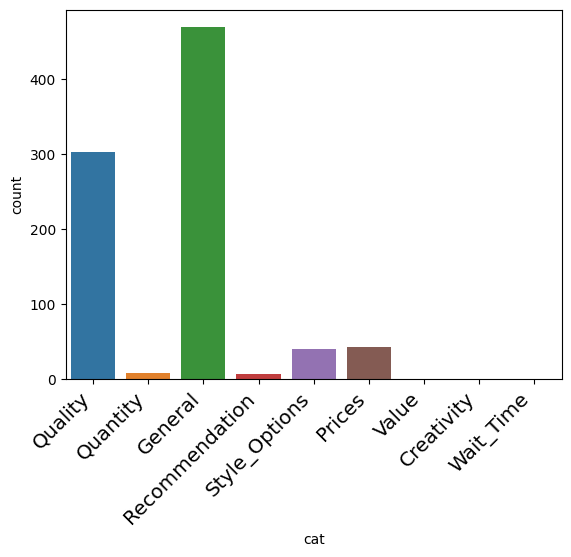

terms       pol       counts
Ambience    positive  46        0.030303
Drinks      positive  28        0.030303
Food        negative  63        0.030303
            positive  262       0.030303
Others      negative  1         0.060606
                      2         0.030303
                      3         0.030303
                      4         0.030303
            neutral   1         0.060606
                      3         0.060606
                      7         0.030303
                      11        0.030303
                      12        0.030303
            positive  1         0.242424
                      2         0.090909
                      4         0.030303
                      16        0.030303
Restaurant  negative  75        0.030303
            positive  145       0.030303
Service     negative  86        0.030303
            positive  86        0.030303
dtype: float64


In [97]:
# percent = df2.value_counts(normalize=True).sort_index()
sb.countplot(x=df2['cat'])
plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='x-large')
plt.show()
print(percent)

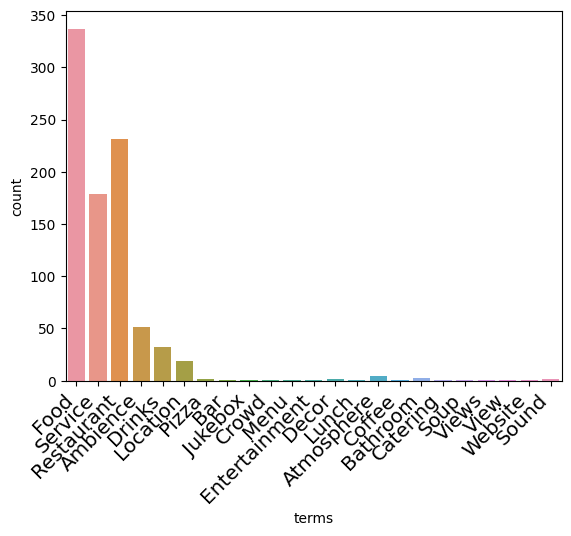

terms       pol       counts
Ambience    positive  46        0.030303
Drinks      positive  28        0.030303
Food        negative  63        0.030303
            positive  262       0.030303
Others      negative  1         0.060606
                      2         0.030303
                      3         0.030303
                      4         0.030303
            neutral   1         0.060606
                      3         0.060606
                      7         0.030303
                      11        0.030303
                      12        0.030303
            positive  1         0.242424
                      2         0.090909
                      4         0.030303
                      16        0.030303
Restaurant  negative  75        0.030303
            positive  145       0.030303
Service     negative  86        0.030303
            positive  86        0.030303
dtype: float64


In [98]:
# percent = df2.value_counts(normalize=True).sort_index()
sb.countplot(x=df2['terms'])
plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='x-large')
plt.show()
print(percent)

In [23]:
import plotly.express as px

In [100]:
fig = px.bar(
    df_cat,
    x="cat",
    y="counts",
    color="pol",
    barmode="stack",
    color_discrete_map={
        "positive": "#52AC5E",
        "negative": "#e34a2d",
        "neutral": "gray",
    },
    title="Categories vs Polarity",
    template="plotly_white",
)

fig.show()

In [101]:
fig = px.bar(
    df_terms,
    x="terms",
    y="counts",
    color="pol",
    barmode="stack",
    color_discrete_map={
        "positive": "#52AC5E",
        "negative": "#e34a2d",
        "neutral": "gray",
    },
    title="Aspect Terms vs Polarity",
    template="plotly_white",
)

fig.show()


In [102]:
fig = px.bar(
    df_terms_cat,
    x="cat",
    y="counts",
    color="terms",
    barmode="stack",
    color_discrete_map={
        "positive": "#52AC5E",
        "negative": "#e34a2d",
        "neutral": "gray",
    },
    title="Categories vs Aspect Terms",
    template="plotly_white",
)

fig.show()

In [25]:
fig = px.pie(df_cat, values='counts', names='cat', title='Categories Count')
# fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.show()

In [104]:
fig = px.pie(df_terms, values='counts', names='terms', title='Terms Count')
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.show()

In [105]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))
# stop_words.update(["laptop", "computer"])

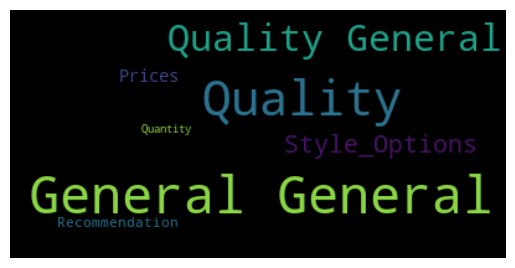

In [106]:
# Start with one review:
text = " ".join(category for category in df2.loc[df2['pol']=="positive", "cat"])

# Create and generate a word cloud image:
# wordcloud = WordCloud(max_words=100, stopwords=stop_words).generate(text)
wordcloud = WordCloud(max_words=100).generate(text)
# max_font_size=50, background_color="white"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

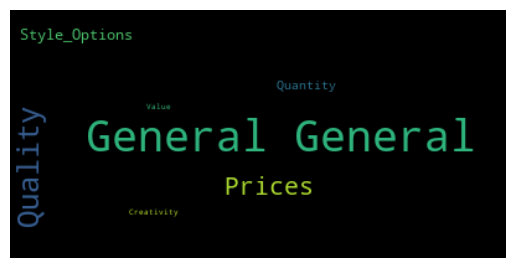

In [107]:
# Start with one review:
text = " ".join(category for category in df2.loc[df2['pol']=="negative", "cat"])

# Create and generate a word cloud image:
# wordcloud = WordCloud(max_words=100, stopwords=stop_words).generate(text)
wordcloud = WordCloud(max_words=100).generate(text)
# max_font_size=50, background_color="white"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

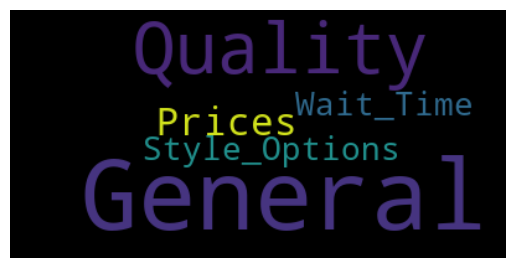

In [108]:
# Start with one review:
text = " ".join(category for category in df2.loc[df2['pol']=="neutral", "cat"])

# Create and generate a word cloud image:
# wordcloud = WordCloud(max_words=100, stopwords=stop_words).generate(text)
wordcloud = WordCloud(max_words=100).generate(text)
# max_font_size=50, background_color="white"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

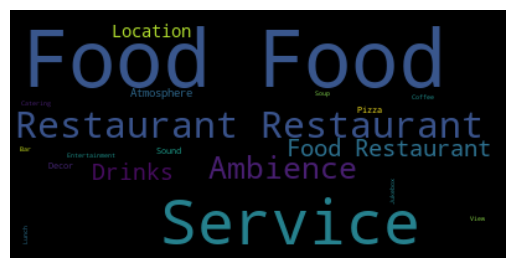

In [109]:
# Start with one review:
text = " ".join(term for term in df2.loc[df2['pol']=="positive","terms"])

# Create and generate a word cloud image:
# wordcloud = WordCloud(max_words=100, stopwords=stop_words).generate(text)
wordcloud = WordCloud(max_words=100).generate(text)
# max_font_size=50, background_color="white"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

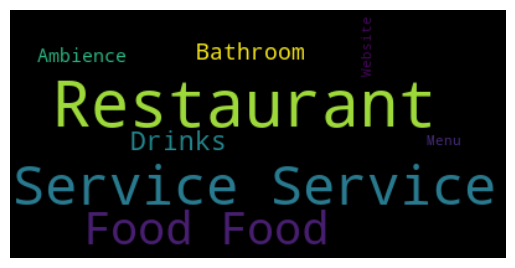

In [110]:
# Start with one review:
text = " ".join(term for term in df2.loc[df2['pol']=="negative","terms"])

# Create and generate a word cloud image:
# wordcloud = WordCloud(max_words=100, stopwords=stop_words).generate(text)
wordcloud = WordCloud(max_words=100).generate(text)
# max_font_size=50, background_color="white"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

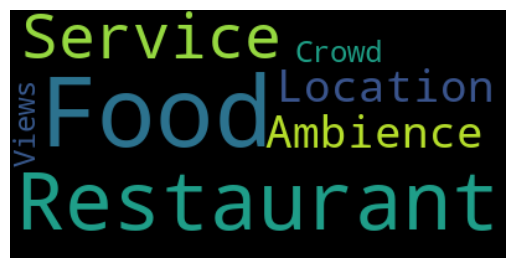

In [111]:
# Start with one review:
text = " ".join(term for term in df2.loc[df2['pol']=="neutral","terms"])

# Create and generate a word cloud image:
# wordcloud = WordCloud(max_words=100, stopwords=stop_words).generate(text)
wordcloud = WordCloud(max_words=100).generate(text)
# max_font_size=50, background_color="white"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [112]:
import plotly.graph_objects as go

fig1 = go.Figure(data=[go.Pie(labels=df_cat.pol, values=df_cat.counts, hole=.3, title='Polarity Count')])
fig1.show()

In [113]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=df_cat.loc[df_cat['pol']=="positive",'cat'], 
                     values=df_cat.loc[df_cat['pol']=="positive",'counts'], 
                      name="pos"), 1, 1) #scalegroup='on',
fig.add_trace(go.Pie(labels=df_cat.loc[df_cat['pol']=="neutral",'cat'], 
                     values=df_cat.loc[df_cat['pol']=="neutral",'counts'], 
                     name="neu"), 2, 1) #scalegroup='on',
fig.add_trace(go.Pie(labels=df_cat.loc[df_cat['pol']=="negative",'cat'], 
                     values=df_cat.loc[df_cat['pol']=="negative",'counts'], 
                     name="neg"), 1, 2) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_cat['pol'], 
                     values=df_cat['counts'], 
                     name="pol"), 2, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.3, hoverinfo="label+percent+name")
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))

fig.show()

In [114]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=df_terms.loc[df_terms['pol']=="positive",'terms'], 
                     values=df_terms.loc[df_terms['pol']=="positive",'counts'], 
                     name="pos"), 1, 1) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_terms.loc[df_terms['pol']=="neutral",'terms'], 
                     values=df_terms.loc[df_terms['pol']=="neutral",'counts'], 
                     name="neu"), 2, 1) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_terms.loc[df_terms['pol']=="negative",'terms'], 
                     values=df_terms.loc[df_terms['pol']=="negative",'counts'], 
                     name="neg"), 1, 2) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_terms['pol'], 
                     values=df_terms['counts'], 
                     name="pol"), 2, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))

fig.show()

In [115]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=df_terms_cat['cat'], 
                     values=df_terms_cat['counts'], 
                     name="category"), 1, 1)
fig.add_trace(go.Pie(labels=df_terms_cat['terms'], 
                     values=df_terms_cat['counts'], 
                     name="term"), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.show()

In [26]:
df_cat.loc[df_cat['counts'] < 20, 'cat'] = 'Others' # Represent less frequently observerd terms
fig = px.pie(df_cat, values='counts', names='cat', title='Categories Count')
fig.show()

In [27]:
df_terms.loc[df_terms['counts'] < 20, 'terms'] = 'Others' # Represent less frequently observerd terms
fig = px.pie(df_terms, values='counts', names='terms', title='Terms Count')
fig.show()

In [118]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=df_cat.loc[df_cat['pol']=="positive",'cat'], 
                     values=df_cat.loc[df_cat['pol']=="positive",'counts'], 
                      name="pos"), 1, 1) #scalegroup='on',
fig.add_trace(go.Pie(labels=df_cat.loc[df_cat['pol']=="neutral",'cat'], 
                     values=df_cat.loc[df_cat['pol']=="neutral",'counts'], 
                     name="neu"), 2, 1) #scalegroup='on',
fig.add_trace(go.Pie(labels=df_cat.loc[df_cat['pol']=="negative",'cat'], 
                     values=df_cat.loc[df_cat['pol']=="negative",'counts'], 
                     name="neg"), 1, 2) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_cat['pol'], 
                     values=df_cat['counts'], 
                     name="pol"), 2, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.3, hoverinfo="label+percent+name")
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))

fig.show()

In [119]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=df_terms.loc[df_terms['pol']=="positive",'terms'], 
                     values=df_terms.loc[df_terms['pol']=="positive",'counts'], 
                     name="pos"), 1, 1) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_terms.loc[df_terms['pol']=="neutral",'terms'], 
                     values=df_terms.loc[df_terms['pol']=="neutral",'counts'], 
                     name="neu"), 2, 1) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_terms.loc[df_terms['pol']=="negative",'terms'], 
                     values=df_terms.loc[df_terms['pol']=="negative",'counts'], 
                     name="neg"), 1, 2) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_terms['pol'], 
                     values=df_terms['counts'], 
                     name="pol"), 2, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))

fig.show()

In [120]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=df_terms_cat['cat'], 
                     values=df_terms_cat['counts'], 
                     name="category"), 1, 1)
fig.add_trace(go.Pie(labels=df_terms_cat['terms'], 
                     values=df_terms_cat['counts'], 
                     name="term"), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))

fig.show()

#### Display results in HTML

This will display the annotated feedbacks in a prettier way using HTML.

In [121]:
import re
from IPython.display import display, HTML
from html import escape

css = """
<style>
    .container {
        background-color: #fff;
        padding: 15px
    }

    p.feedback {
        margin-top: 5px;
        color: #595f6d;
        line-height: 2
    }

    .annotation {
        color: #777;
        padding: 2px;
        font-weight: bold !important;
        border-radius: 1px;
        border-bottom: 4px solid;
    }

    .aspect {
        color: #6eb2e7;
        padding-left: 10px;
        font-size: 12px;
    }
</style>
"""


def ireplace(text, old, new):
    pattern = re.compile(old, re.IGNORECASE)
    return pattern.sub(new, text)


html = f"{css}"

for i, review in enumerate(df.to_dict("records")):
    text = escape(review["text"])

    try:
        for ann in analysis_results[i]:
            color = "#2bbf6d" if ann["sentiment"] == "positive" else "#cf2a43"

            text = ireplace(
                text,
                ann["segment"],
                f"<span class='annotation' style='border-color: {color}'>{escape(ann['segment'])} <span class='aspect'>{ann['aspect']}<span class='category'>{'#'+ann['category']}</span></span>",
            )

        html += f"""

            <div class='container'>
                <p class='feedback'>{text}</p>
            </div>
        """

    except Exception as e:
        print(f"Failed to parse {review['text']} {e}")
        continue

display(HTML(html))


#### Accuracy

In [122]:
import pandas as pd
from ast import literal_eval

In [123]:
#loading the data
data = pd.read_csv("./data/output/restaurant/rest_out_final_exp1.csv")
data.head(5)

,text,term_true,cat_true,pol_true,analysis,term,cat,pol,seg
0,yum !,['FOOD'],['QUALITY'],['2'],"[{'category': 'Quality', 'aspect': 'Food', 'se...",['Food'],['Quality'],[2],['yum !']
1,serves really good sushi .,['FOOD'],['QUALITY'],['2'],"[{'category': 'Quality', 'aspect': 'Food', 'se...",['Food'],['Quality'],[2],['serves really good sushi']
2,not the biggest portions but adequate .,"['FOOD', 'FOOD']","['STYLE_OPTIONS', 'STYLE_OPTIONS']","['1', '1']","[{'category': 'Quantity', 'aspect': 'Food', 's...","['Food', 'Food']","['Quantity', 'Quantity']","[0, 2]","['not the biggest portions', 'but adequate']"
3,green tea creme brulee is a must !,['FOOD'],['QUALITY'],['2'],"[{'category': 'Quality', 'aspect': 'Food', 'se...",['Food'],['Quality'],[2],['green tea creme brulee is a must !']
4,it has great sushi and even better service .,"['FOOD', 'SERVICE']","['QUALITY', 'GENERAL']","['2', '2']","[{'category': 'Quality', 'aspect': 'Food', 'se...","['Food', 'Service']","['Quality', 'General']","[2, 2]","['it has great sushi', 'even better service']"


In [124]:
data['term_true'] = data['term_true'].apply(literal_eval)
data['cat_true'] = data['cat_true'].apply(literal_eval)
data['pol_true'] = data['pol_true'].apply(literal_eval)

data['term'] = data['term'].apply(literal_eval)
data['cat'] = data['cat'].apply(literal_eval)
data['pol'] = data['pol'].apply(literal_eval)

In [125]:
def convert_lower_str(term, cat, pol):
    list_term = []
    list_cat = []
    list_pol = []
    
    # Gets the size of a and b.
    sizeA, sizeB, sizeC = len(term), len(cat), len(pol)

    # print(max([sizeA, sizeB, sizeC]))
    big = max(enumerate([sizeA, sizeB, sizeC]),key=lambda x: x[1])[0]

    if big == 0:
        zeros = ['nil' for _ in range(abs(sizeA-sizeB))]
        zeros1 = ['nil' for _ in range(abs(sizeA-sizeC))]
        cat += zeros
        pol += zeros1
    elif big == 1:
        zeros = ['nil' for _ in range(abs(sizeA-sizeB))]
        zeros1 = ['nil' for _ in range(abs(sizeB-sizeC))]
        term += zeros
        pol += zeros1
    elif big == 2:
        zeros = ['nil' for _ in range(abs(sizeA-sizeC))]
        zeros1 = ['nil' for _ in range(abs(sizeB-sizeC))]
        term += zeros
        cat += zeros1
        
    for i in range(0, len(term)):
        list_term.append(str(term[i]).lower())
        list_cat.append(str(cat[i]).lower())
        list_pol.append(str(pol[i]).lower())
    return pd.Series([list_term, list_cat, list_pol])
data[["term_true","cat_true","pol_true"]] = data.apply(lambda x: convert_lower_str(x["term_true"], x["cat_true"], x["pol_true"]), axis=1)
data[["term","cat","pol"]]= data.apply(lambda x: convert_lower_str(x["term"], x["cat"], x["pol"]), axis=1)

In [126]:
def terms_pol(term, cat, pol):
    list_temp = []
    for i in range(0, len(term)):
        list_temp.append([str(term[i]).lower(), str(cat[i]).lower(), str(pol[i]).lower()])
    return list_temp
data["True"]= data.apply(lambda x: terms_pol(x["term_true"], x["cat_true"], x["pol_true"]), axis=1)
data["Pred"]= data.apply(lambda x: terms_pol(x["term"], x["cat"], x["pol"]), axis=1)

In [127]:
# def compare(list1, list2):
#     for val in list1:
#         if val in list2:
#             return 1
#     return 0
def compare_all(list1, list2):
    if len(list1)==len(list2):
        if all([item in list1 for item in list2]):
            return 1
        else: 
            return 0
    else:
        return 0

In [128]:
data["All_Matched"]= data.apply(lambda x: compare_all(x["True"], x["Pred"]), axis=1)
data["T_All_Matched"]= data.apply(lambda x: compare_all(x["term_true"], x["term"]), axis=1)
data["C_All_Matched"]= data.apply(lambda x: compare_all(x["cat_true"], x["cat"]), axis=1)

In [129]:
print("Number of sentences: ", data.shape[0])
print("Acc of aspect term  %: ", (data["T_All_Matched"].sum()/data.shape[0])*100)
print("Acc of aspect category  %: ", (data["C_All_Matched"].sum()/data.shape[0])*100)
print("Overall acc %: ", (data["All_Matched"].sum()/data.shape[0])*100)

Number of sentences:  583
Acc of aspect term  %:  63.12178387650086
Acc of aspect category  %:  62.264150943396224
Overall acc %:  51.97255574614065
